# Visualización Estadística en Python

Por **Eduardo Graells-Garrido (egraells@udd.cl)**.

En este notebook exploraremos distintos tipos de visualizaciones para estadística. Lo haremos con las bibliotecas `matplotlib` y `seaborn`, trabajando sobre `pandas`.

Trabajaremos con datos *reales*: la encuesta CASEN del año 2013 y la encuesta EOD del año 2012. La primera es de caracterización socio-económica del país y la segunda de transporte en Santiago. Específicamente, realizaremos un análisis exploratorio de estas encuestas, enfocándonos en preguntas específicas que plantearemos, y también a las preguntas que vayan surgiendo en clases.

Luego cruzaremos los datos de ambas encuestas para ver si encontramos algún link interesante entre la socio-economía y la movilidad de las comunas de Santiago.

Comencemos.

## Preámbulo

El primer paso es importar las bibliotecas necesarias para poder trabajar. Usaremos las bibliotecas `numpy` (vectores), `pandas`(DataFrames), `matplotlib` (visualización de bajo nivel) y `seaborn` (visualización estadística). 

Ya tienen experiencia con estas cuatro bibliotecas, pero hoy profundizaremos un poco más en las dos últimas.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Esto configura la apariencia de los gráficos utilizando configuraciones de seaborn
sns.set(context='poster', style='ticks', palette='inferno', font='Linux Biolinum O')

# Esto es una instrucción de Jupyter que hace que los gráficos se desplieguen en el notebook
%matplotlib inline

## `matplotlib`

`matplotlib` es una biblioteca de **bajo nivel** para visualización en Python, con un paradigma **imperativo**.

  * De bajo nivel quiere decir que entrega las primitivas gráficas necesarias para crear visualizaciones más complejtas.
  * Imperativo quiere decir que se focaliza en las instrucciones que recibe la biblioteca, ya que no _abstrae_ las operaciones o codificaciones visuales de modo que operemos sobre éstas.

## `seaborn`

`seaborn` es una biblioteca que se construye _sobre_ `matplotlib`, y que incluye gráficos estadísticos y algunas funcionalidades avanzadas de modelamiento y reducción de complejidad. Esto permite _hacer más con menos código_. 

Al mismo tiempo, `seaborn` incluye opciones para trabajar con la codificación visual de manera más efectiva que `matplotlib`, por ejemplo, a través de la facilitación de elección de paletas de colores, o de la detección de parámetros siguiendo buenas prácticas.

Y para completar más esta oferta, `seaborn` es directamente compatible con `pandas`. `matplotlib` también, pero no de manera nativa, por lo que todo lo que se relaciona con `pandas` requiere más trabajo.

Oh, vemos que no solamente hizo el gráfico, sino que incluso etiquetó automáticamente el eje $x$.

Sin embargo, en `seaborn` la idea no es reemplazar los métodos de `matplotlib`. En realidad, lo que haremos será trabajar de manera diferente. Lo primero que debemos hacer es cambiar el formato de los datos. 

En `seaborn` se trabaja con **tidy data**. O datos ordenaditos.

En el dataframe `df` tenemos tres observaciones por fila. No es un dataframe ordenadito. Un dataframe ordenadito tendría una observación por fila. 

(Aquí hay dos explicaciones interesantes sobre _tidy data_: en [R](http://garrettgman.github.io/tidying/) y en [Python](http://www.jeannicholashould.com/tidy-data-in-python.html). El paper que explica el razonamiento detrás está [aquí](http://courses.had.co.nz.s3-website-us-east-1.amazonaws.com/12-rice-bdsi/slides/07-tidy-data.pdf)).

Afortunadamente, `pandas` nos permite convertir un dataframe en formato _longform_ a uno en formato _tidy_ con la función `pd.melt`.

## Analicemos Datos Reales

Exploremos y expandamos nuestra exploración de visualizaciones estadísticas a través del análisis de datos reales. Utilizaremos la Encuesta Origen-Destino de Viajes de Santiago (2012) y la encuesta CASEN (2013).

In [2]:
def load_casen():
    # el archivo Casen2013.csv.gz contiene la base de datos en formato comprimido.
    casen = pd.read_csv('./input/2013_casen_survey/Casen2013.csv.gz', sep=',', 
                        encoding='iso-8859-1')
    
    # nos quedaremos solamente con la Región Metropolitana
    casen = casen[casen.region == 13].copy()
    
    # Esta es una manera fea de transformar los identificadores de comuna en nombres
    name_map = dict(zip([13101, 13102, 13103
    ,13104,13105,13106,13107,13108,13109,13110,13111,13112,13113,13114,13115,13116,13117,13118,13119,13120,13121,13122,13123
    ,13124,13125,13126,13127,13128,13129,13130,13131,13132,13201,13202,13203,13301,13302,13303,13401,13402,13403,13404,13501,
                     13502, 13503, 13504, 13505, 13601, 13602, 13603, 13604, 13605],
        map(lambda x: x.title(), ['Santiago', 'Cerrillos', 'Cerro Navia', 'Conchalí',
        'El Bosque', 'Estación Central', 'Huechuraba', 'Independencia', 'La Cisterna',
        'La Florida', 'La Granja', 'La Pintana',
        'La Reina','Las Condes','Lo Barnechea','Lo Espejo', 'Lo Prado',
        'Macul','Maipú','Ñuñoa','Pedro Aguirre Cerda','Peñalolén',
        'Providencia','Pudahuel','Quilicura','Quinta Normal','Recoleta','Renca',
        'San Joaquín','San Miguel','San Ramón','Vitacura','Puente Alto','Pirque',
        'San José de Maipo','Colina','Lampa','Tiltil','San Bernardo','Buin',
        'Calera de Tango','Paine','Melipilla','Alhué','Curacaví','María Pinto','San Pedro',
        'Talagante','El Monte','Isla de Maipo','Padre Hurtado','Peñaflor'
        ])))

    # aquí aplicamos la transformación y guardamos el resultado en una nueva columna
    casen['municipality'] = casen['comuna'].map(lambda x: name_map[x])
    return casen

casen = load_casen()
casen.shape

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (16,18,25,27,38,51,114,234,286,312,316,332,349,360,369) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(36680, 602)

In [3]:
# la encuesta tiene tantas columnas que hacemos esto para imprimirlas todas
pd.set_option('max_columns', 1000)

In [4]:
casen.sample(3)

,Unnamed: 0,folio,o,region,comuna,zona,pco1,sexo,edad,ecivil,h5l,h5h,pareja,nucleo,pco2,h8,h8esp,h9,h9esp,e1,e2a,e2b,e2c,e3,e4,e4esp,e5,e5esp,e6a,e6b,e6c,e6d,e7,e8nom,e8dir,e8com,e8com_cod,e8rbd,e8dv,e8depen,e8te,e9,e10,e11a,e11b,e11c,e11d,e11e,e12a,e12b1,e12b2,e12esp,e13pbu,e13pbt,e13pbd,e13pbm,e13bu,e13bt,e13bd,e13bm,e13bpc,e13mu,e13mt,e13md,e13mm,e14a,e14b,e15,e16,e17t1,e18m1,e18p1,e17t2,e18m2,e18p2,e0,o1,o2,o3,o4,o5,o6,o7r1,o7r2,o8,o9a,oficio4,oficio1,o9b,o10,o11,o12,o13,o14,o15,o16,o17,o18,o19,o20,o21,rama4_sub,rama1_sub,o22,o23,rama4,rama1,o24,o25,o26,o27,o28,o29,o30,o30esp,o31a,o31b,o31c,o0,oficio4_n,rama4_sub_n,rama4_n,ych1,ych2,ych3,y2d,y2h,y19n,y21a,y21b,y27ai,y27at,y27bi,y27bt,y27ci,y27ct,y27di,y27dt,y27ei,y27et,y28a,y28b,y28c,y28d,y28e,y0,s1,s2a,s2b,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15a,s15b,s16,s17,s18,s19,s20,s21a,s21b,s21c,s22a,s22b,s22c,s23a,s23b,s23c,s24a,s24b,s24c,s25a,s25b,s25c,s26a,s26b,s26c,s27a,s27b,s27c,s27d,s28a,s28b,s28c,s28d,s29a,s29b,s29c,s29d,s30a,s30b,s30c,s30d,s31,s32,s33,s34t1,s34t2,s34t3,s35o1,s35o2,s35o3,s36a,s36b,s36c,s36d,s36e,s36f,s37a,s37b,s37c,s37d,s37e,s37f,s37g,s38a,s38b,s38c,s39a,s39b,s39c,s39d,s39e,s0,r1a,r1aesp,r1a_cod,r1b,r1besp,r1b_c_cod,r1b_p_cod,r1c,r2,r2esp,r2_c_cod,r2_p_cod,r3,r4mn,r4pn,r5mc,r5pc,r6,r7,r8,r9,r10,r11a,r11b,r12,r13a,r13b,r13c,r13d,r13e,r13f,r14a,r14b,r14c,r14d,r14e,r14f,r15,r16,r17,r18a,r18b,r18c,r18d,r18e,r18f,r18g,r18h,r19,r20,r211,r212,r213,r21esp,r0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v11m,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v23esp,v24,v25,v26,v26esp,v27,v28,v29a,v29b,v29c,v29d,v29e,v30,v31,v32a,v32b,v32c,v32d,v32e,v33,v33esp,v34,v35,v36,v37,v38_1,v38_2,v38_3,v38_4,v38_5,v38_6,v38_7,v38_8,v38_9,v38_10,v38_11,v38_12,v38esp,v39_1,v39_2,v39_3,v39_4,v39_5,v39_6,v39_7,v39_8,v39_9,v39_10,v39esp,v40_1,v40_2,v40_3,v40_4,v40_5,v40_6,v40_7,v40_8,v40esp,v0a1,v0a2,v0a3,v0b,y0101c,y0102,y0103,y0301,y0302,y0303,y0304,y0305,y0306,y0401,y0402,y0403,y0404,y0501,y0502,y0503,y0504,y0505,y0506,y0507,y0508,y0509,y0510,y0511,y0512,y0601,y0701c,y0702,y0703,y0801,y0901,y1001,y1101,y1102,y1103,yre1,yama,ymes,yfa1,yfa2,ytro,yta1,yta2,ydes,yah1,yah2,yrut,yre2,yre3,yac2,yids,ydon,ydim,yotr,yfam,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2201,y2202,y2203,y2204,y2205,y2301,y2302,y2303,y2401,y2501,y2502,y2503,y2504,y2505,y2506,y2507,y2601,y2602,y2603,y2701c,yinv,ymon,yorf,yotp,yosa,yosi,yautcor,ysub,ytotcor,y0101ch,y0301h,y0302h,y0303h,y0304h,y0305h,y0306h,y0401h,y0402h,y0403h,y0404h,y0501h,y0502h,y0503h,y0504h,y0505h,y0506h,y0507h,y0508h,y0509h,y0510h,y0511h,y0512h,y0601h,y0701ch,y0801h,y0901h,y1001h,y1101h,yre1h,yamah,ymesh,yfa1h,yfa2h,ytroh,yta1h,yta2h,ydesh,yah1h,yah2h,yruth,yre2h,yre3h,yac2h,yidsh,ydonh,ydimh,yotrh,yfamh,y2001h,y2002h,y2003h,y2004h,y2005h,y2006h,y2007h,y2008h,y2009h,y2010h,y2201h,y2202h,y2203h,y2204h,y2205h,y2301h,y2302h,y2303h,y2401h,y2501h,y2502h,y2503h,y2504h,y2505h,y2506h,y2507h,y2601h,y2602h,y2603h,y2701ch,yinvh,ymonh,yorfh,yotph,yosah,yosih,yautcorh,ysubh,yaimcorh,ytotcorh,yoprcor,yoprcorh,ytrabajocor,ytrabajocorh,yoautcorh,yoautcor,ysuf,ysufh,yces,ycesh,ypbs,ypbsh,yaps,yapsh,ybpfe,ybpfeh,ymonecorh,ypchautcor,ypchtrabajo,ypchtot,expr,expc,expr_r20,varstrat,varunit,fecha,pobreza_mn,pobreza_multi,dau_mn,dautr_mn,qaut_mn,qautr_mn,numper,asiste,esc,educ,depen,activ,indmat,indsan,calgobviv,iai,iae,hacinamiento,municipality
176314,176314,1.311911e+11,3,13,13119,1,3,1,30,7,NaN,NaN,7,1,3,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,11,1.0,2.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONTADOR TESORERO,2411.0,2.0,GESTIONES Y SUPERVISION COBRANZAS,45.0,3.0,1.0,2010.0,3.0,5.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,HERRAMIENTAS ELECTRICAS,7412.0,11.0,D,D,3.0,2.0,NaN,1.0,1.0,NaN,4.0,NaN,NaN,1.0,2411.0,NaN,7412.0,1,2.0,NaN,20.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
print(list(casen.columns))

['Unnamed: 0', 'folio', 'o', 'region', 'comuna', 'zona', 'pco1', 'sexo', 'edad', 'ecivil', 'h5l', 'h5h', 'pareja', 'nucleo', 'pco2', 'h8', 'h8esp', 'h9', 'h9esp', 'e1', 'e2a', 'e2b', 'e2c', 'e3', 'e4', 'e4esp', 'e5', 'e5esp', 'e6a', 'e6b', 'e6c', 'e6d', 'e7', 'e8nom', 'e8dir', 'e8com', 'e8com_cod', 'e8rbd', 'e8dv', 'e8depen', 'e8te', 'e9', 'e10', 'e11a', 'e11b', 'e11c', 'e11d', 'e11e', 'e12a', 'e12b1', 'e12b2', 'e12esp', 'e13pbu', 'e13pbt', 'e13pbd', 'e13pbm', 'e13bu', 'e13bt', 'e13bd', 'e13bm', 'e13bpc', 'e13mu', 'e13mt', 'e13md', 'e13mm', 'e14a', 'e14b', 'e15', 'e16', 'e17t1', 'e18m1', 'e18p1', 'e17t2', 'e18m2', 'e18p2', 'e0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7r1', 'o7r2', 'o8', 'o9a', 'oficio4', 'oficio1', 'o9b', 'o10', 'o11', 'o12', 'o13', 'o14', 'o15', 'o16', 'o17', 'o18', 'o19', 'o20', 'o21', 'rama4_sub', 'rama1_sub', 'o22', 'o23', 'rama4', 'rama1', 'o24', 'o25', 'o26', 'o27', 'o28', 'o29', 'o30', 'o30esp', 'o31a', 'o31b', 'o31c', 'o0', 'oficio4_n', 'rama4_sub_n', 'rama4_n',

Como pueden ver, son muchísimas columnas -- es una encuesta compleja. En la carpeta `input` hay un archivo en PDF donde se explica el significado y posibles valores de cada respuesta.

### Relación entre Satisfacción con la Vida e Ingreso

Una de las preguntas que me llama mucho la atención es la que dice:

> Considerando todas las cosas, ¿qué tan satisfecho se encuentra con su vida?

La respuesta va de 1 (insatisfacción total) a 10 (satisfacción total).

Estudiaremos las relaciones entre esa pregunta, que tiene código `r20`, con otras variables del dataset.

Partamos con el ingreso del hogar, que tiene código `ytotcorh`. Podemos ver su distribución con un `sns.distplot`:

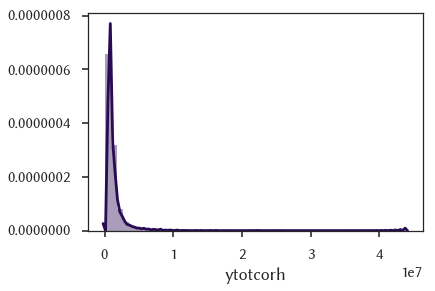

In [6]:
sns.distplot(casen.ytotcorh)

¡Oh! Como los ingresos de la RM están sesgados, la distribución se ve bastante fea. Quizás deberíamos probar otro tipo de visualización, como las que entrega `sns.factorplot`:

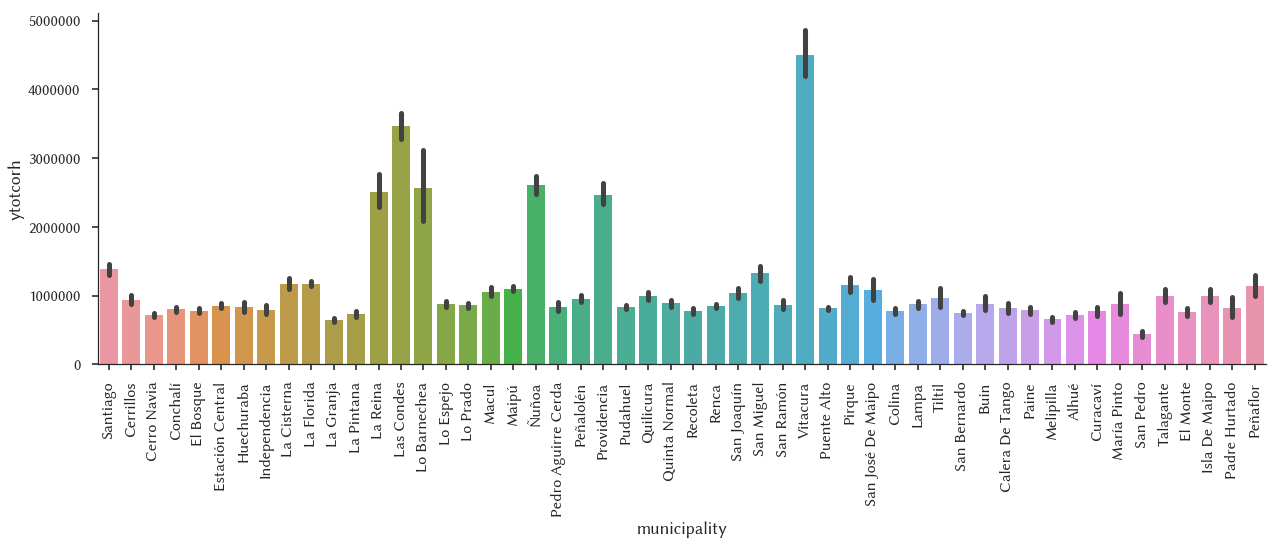

In [7]:
sns.factorplot(x='municipality', y='ytotcorh', data=casen, aspect=3, size=6, kind='bar')
plt.xticks(rotation=90);

Que bien, esto ya nos sirve para empezar a hacer análisis. Vemos que cada comuna tiene una barra asociada, que muestra el ingreso promedio por comuna, y una barra de error que representa la variabilidad, mostrando el intervalo de confianza del 95%. 

Lo que nos gustaría es poder ordenarlo. Para eso debemos calcular el orden nosotros:

In [8]:
municipalities_by_income = (casen.groupby('municipality')
                            .aggregate({'ytotcorh': 'mean'})
                            .sort_values('ytotcorh'))

También aprovecharemos de usar un color fijo para las barras. No tiene sentido en este caso que las barras tengan colores diferentes:

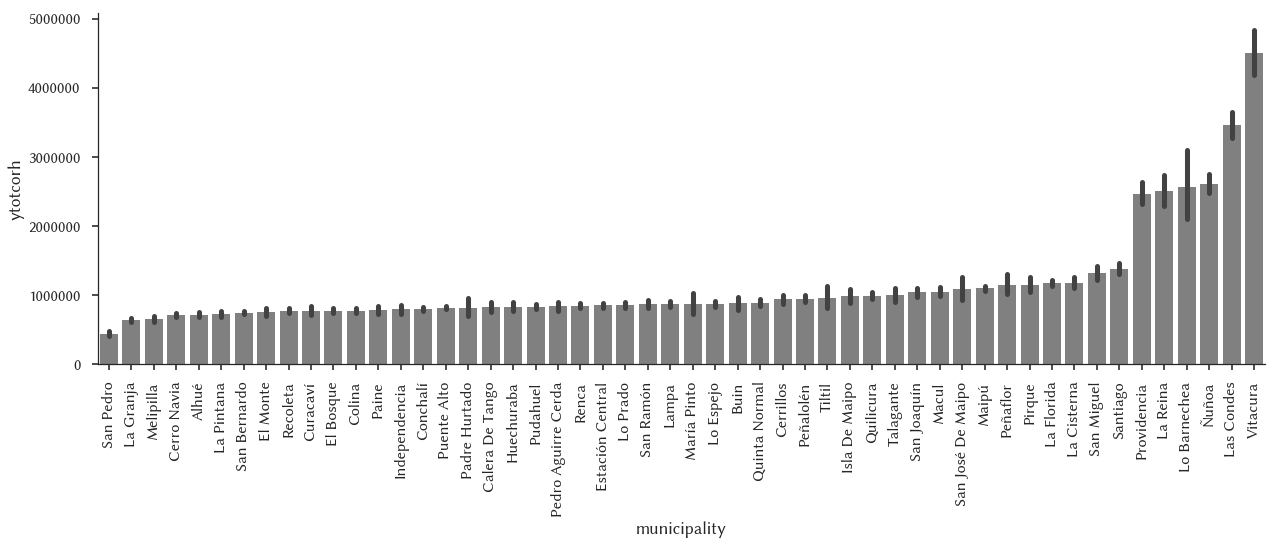

In [9]:
sns.factorplot(x='municipality', y='ytotcorh', data=casen, aspect=3, size=6, kind='bar',
               order=municipalities_by_income.index, color='grey')
plt.xticks(rotation=90);

¡Qué bien! Es un gráfico sencillo pero que a la vez comunica muchas cosas. Vemos la distribución del ingreso por comunas de manera impactante. Simplificando, esencialmente hay tres grupos de comunas: las muy, muy ricas, las ricas, y el resto, desde Santiago hacia abajo.

Digo _simplificando_ porque hasta aquí hemos obviado algunas cosas. Por un lado, cada hogar encuestado tiene una ponderación dentro de la muestra, llamada _factor de expansión_, que hemos ignorado. Y el ingreso que estamos viendo es a nivel de hogar, no de persona entrevistada. 

Y cada persona entrevistada es una observación en la base de datos. Es decir, hemos estado considerando duplicados en ese gráfico.

In [10]:
# uso la conversión a int para que se muestre el valor completo.
casen.folio.astype(np.int).head(10)

161379    131011001021
161380    131011001031
161381    131011001031
161382    131011001071
161383    131011001091
161384    131011001091
161385    131011001111
161386    131011001111
161387    131011001121
161388    131011001121
Name: folio, dtype: int64

Como se observa, hay folios repetidos.

In [11]:
casen.ytotcorh.head(10)

161379    4340000
161380    3020463
161381    3020463
161382    1468333
161383    3947750
161384    3947750
161385     518333
161386     518333
161387    5625292
161388    5625292
Name: ytotcorh, dtype: int64

Y por tanto, ingresos también. Hagamos un dataframe sin duplicados:

In [12]:
casen_homes = casen.drop_duplicates('folio', keep='first').copy()
casen.shape, casen_homes.shape

((36680, 602), (10981, 602))

In [13]:
municipalities_by_home_income = (casen_homes.groupby('municipality')
                            .aggregate({'ytotcorh': 'mean'})
                            .sort_values('ytotcorh')
                            .rename(columns={'ytotcorh': 'home_income'}))
#municipalities_by_home_income

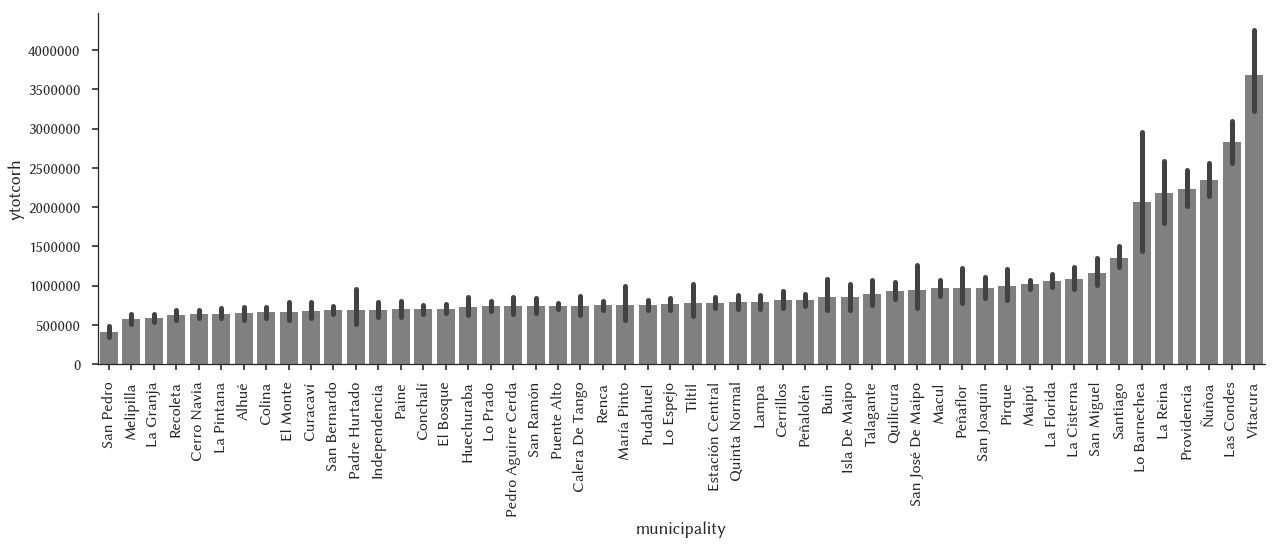

In [14]:
sns.factorplot(x='municipality', y='ytotcorh', data=casen_homes, aspect=3, size=6, kind='bar',
               order=municipalities_by_home_income.index, color='grey')
plt.xticks(rotation=90);

Quizás al ver los gráficos nos cuesta encontrar la diferencia. Podemos hacer una rápida exploración para ver quiénes cambiaron.

In [15]:
municipality_features = municipalities_by_income.join(municipalities_by_home_income)

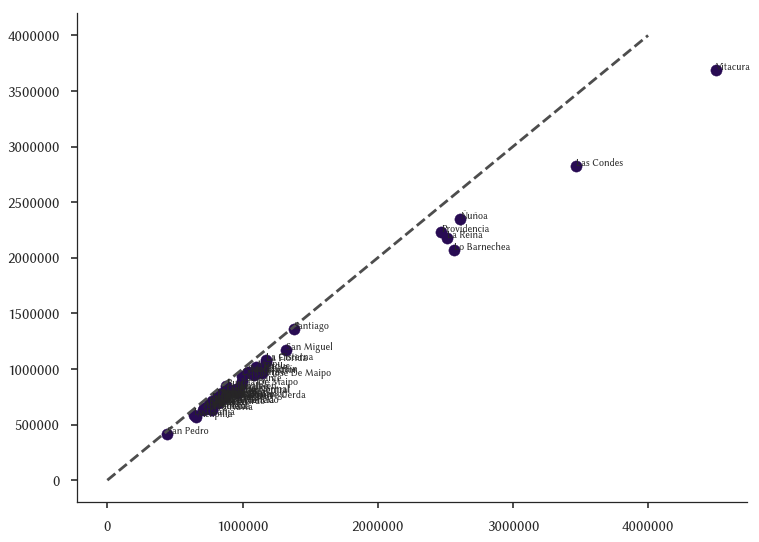

In [16]:
plt.figure(figsize=(12,9))
plt.scatter(municipalities_by_income.ytotcorh, municipality_features.home_income)
plt.plot([0, 4*10**6], [0, 4*10**6], ls="--", c=".3")
for idx, row in municipality_features.iterrows():
    plt.annotate(xy=(row.ytotcorh, row.home_income), s=idx)
sns.despine()

Las comunas que están más cerca de la diagonal son las que tenían menos error. Las comunas más ricas tenían un error más pronunciado, pero ya que ganaban más dinero era esperable.

Ahora empecemos a mirar la **satisfacción con la vida**.

In [17]:
casen.r20.sample(10)

163231    5.0
175350    9.0
181204    NaN
191248    NaN
187212    NaN
175670    NaN
190892    5.0
194491    NaN
197251    5.0
171158    NaN
Name: r20, dtype: float64

Lamentablemente no todas las personas respondieron esa pregunta, por eso hay `NaN`s. Veamos los resultados:

In [18]:
pd.isnull(casen.r20).sum(), casen.shape[0]

(22213, 36680)

Solamente 22 mil de 36 mil. Contemos la cantidad de respuestas utilizando el método `sns.countplot`, que es un histograma _categórico_. Recordemos que el histograma discretiza una variable continua en _bins_. En este caso eso no es completamente adecuado, porque no contaremos la cantidad de respuestas entre 4.5 y 5.5 (por dar un ejemplo). Queda así:

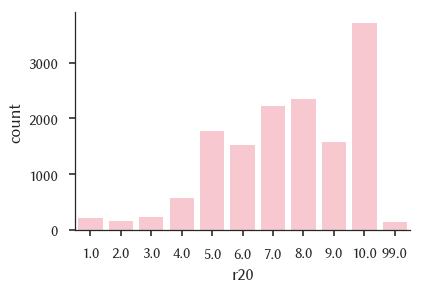

In [19]:
sns.countplot(casen.r20, color='pink')
sns.despine()

Si vemos el PDF de la encuesta sabremos que el valor `99` es "No responde." No conozco la diferencia entre `99` y `NaN`. Seguro es semántica: quizás alguien en `NaN` no estaba habilitado para responder, mientras que `99` es _decidir_ no responder. Sin embargo, esto no se especifica en el documento.

Guardemos las respuestas válidas:

In [20]:
casen_satisfaction = casen[casen.r20 <= 10].copy()
casen_satisfaction.shape

(14325, 602)

Y estimemos la distribución por comunas, manteniendo el orden que teníamos antes.

Esta vez usaremos `sns.factorplot` con `kind=point`, que es más fácil de comparar que el gráfico de barras, pero hay que considerar que el gráfico no parte en 0, por lo que las diferencias son más pequeñas de lo que puede observarse:

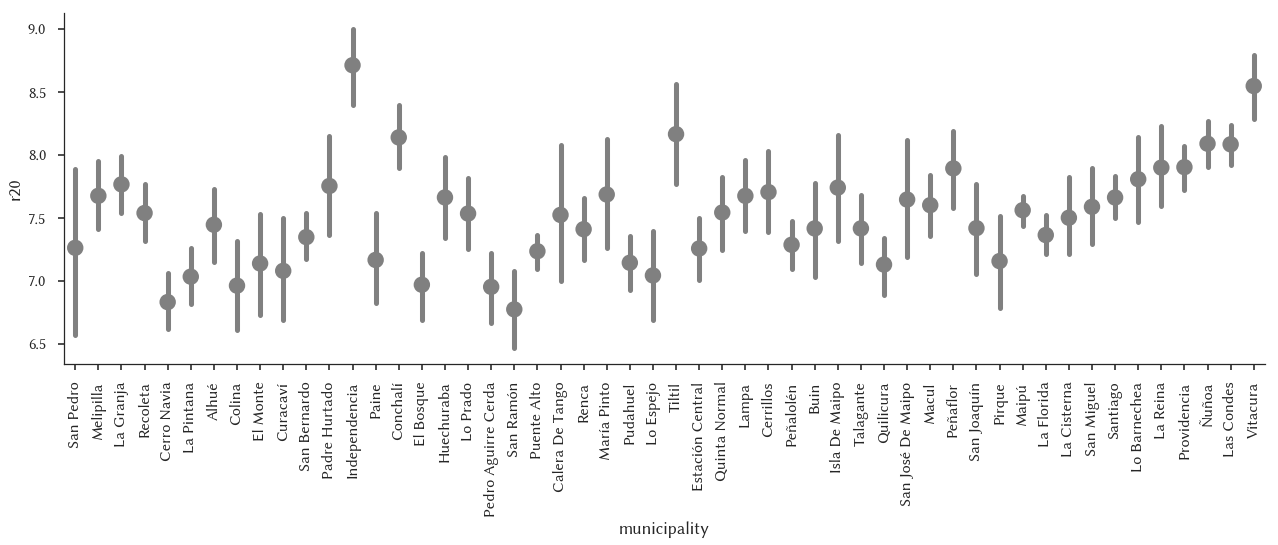

In [21]:
sns.factorplot(x='municipality', y='r20', data=casen_satisfaction, aspect=3, size=6, kind='point',
               order=municipalities_by_home_income.index, color='grey', join=False)
plt.xticks(rotation=90);

Oh, pasa algo muy interesante. El orden de la pregunta `r20` no calza del todo con el orden de `ytotcorh`. Lo estudiaremos más adelante.

Antes, quizás podamos ver la distribución de `r20` de acuerdo a otras variables. Por ejemplo, el estado civil. En el PDF se menciona el siguiente diccionario:

  * 1: Casado
  * 2: Conviviente
  * 3: Anulado
  * 4: Separado
  * 5: Divorciado
  * 6: Viudo
  * 7: Soltero
  
El `sns.countplot` correspondiente es:

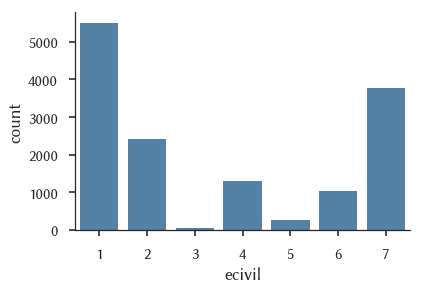

In [22]:
sns.countplot(casen_satisfaction.ecivil, color='steelblue')
sns.despine()

Vemos que solamente las categorías 1, 2, 4, 6 y 7 tienen más de 1000 muestras. Enfoquémonos en ellas.

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


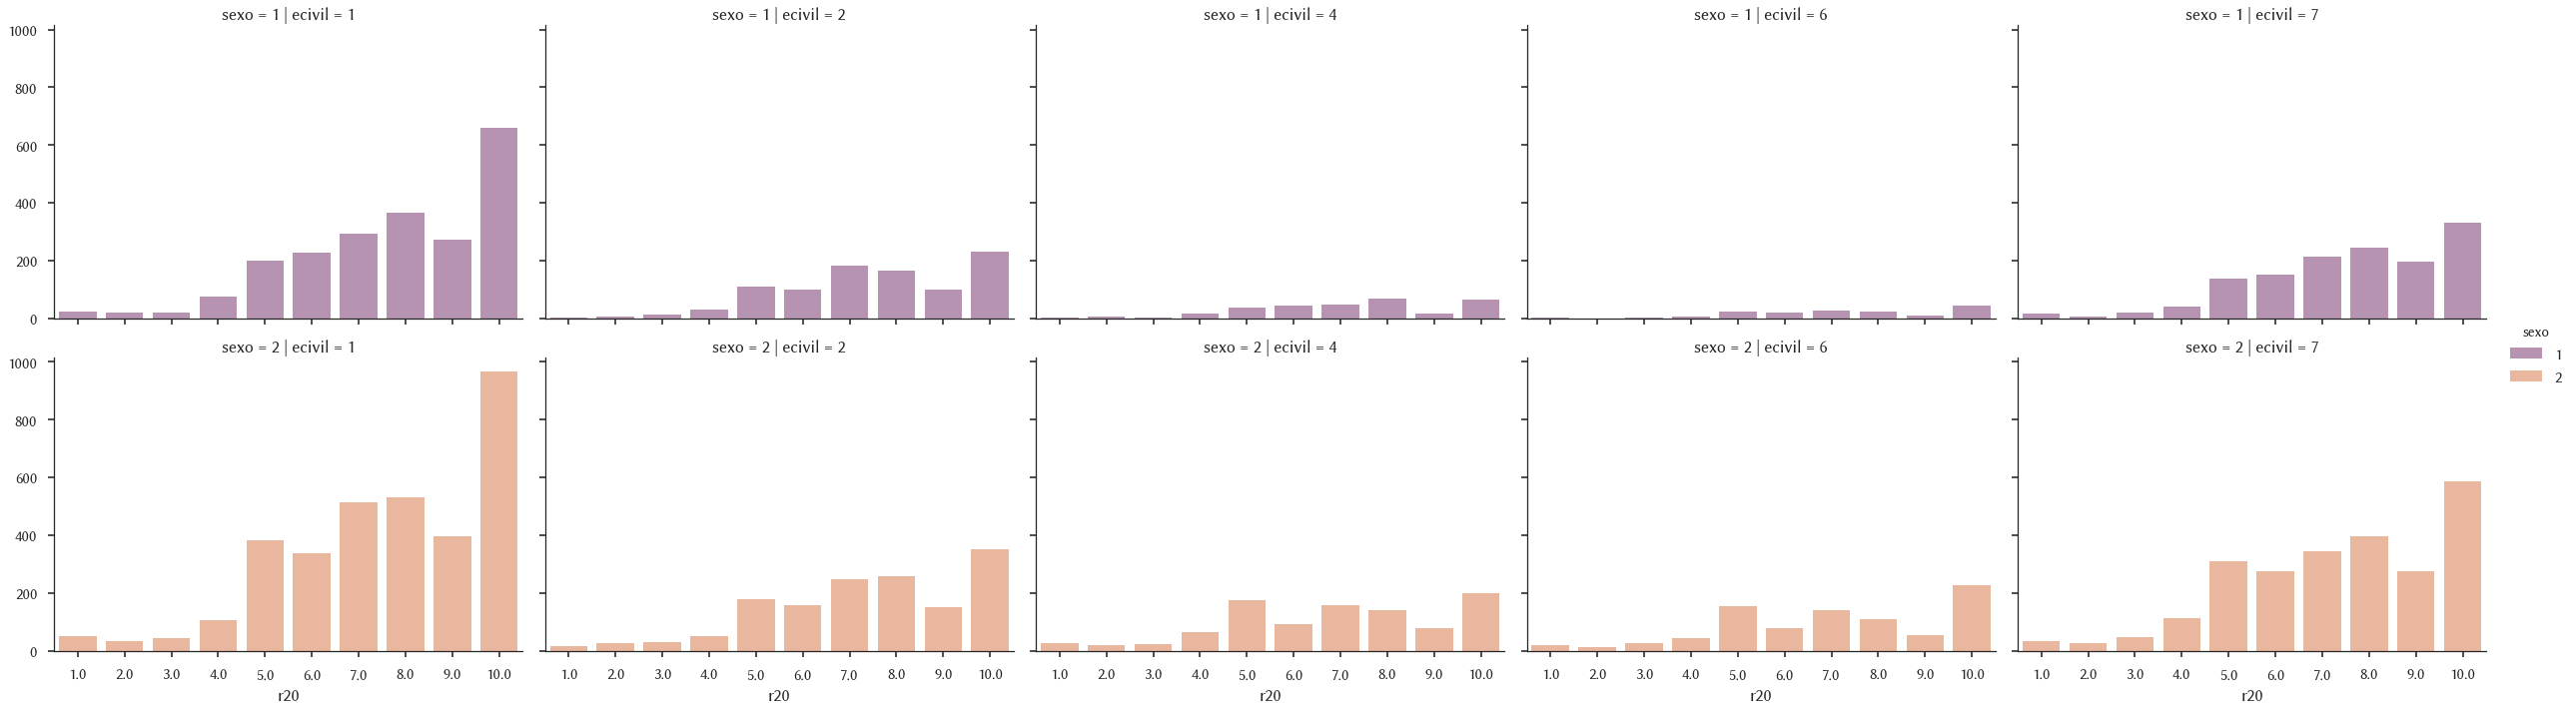

In [23]:
g = sns.FacetGrid(data=casen_satisfaction, col='ecivil', row='sexo', hue='sexo',
                  aspect=1.4, size=5, col_order=[1,2,4,6,7], palette='inferno')
g.map(sns.countplot, 'r20', alpha=0.5)
g.add_legend()

Aunque es un gráfico completo, cuesta hacer las comparaciones. Recurramos nuevamente a `sns.factorplot`:

(pd: les dejo como misterio los valores de la variable `sexo`. ¿pueden adivinarla?)

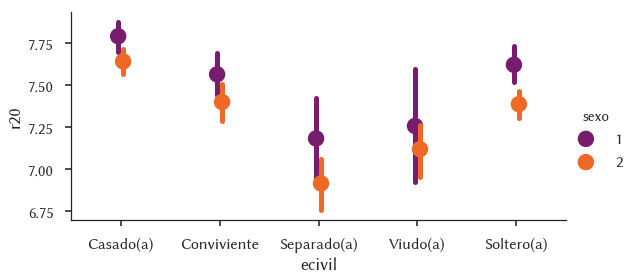

In [24]:
g = sns.factorplot(x='ecivil', y='r20', data=casen_satisfaction, order=[1,2,4,6,7], 
              kind='point', aspect=2, join=False, hue='sexo', dodge=True, palette='inferno')
g.set_xticklabels(labels=['Casado(a)', 'Conviviente', 'Separado(a)', 'Viudo(a)', 'Soltero(a)'])

Noten que usamos el parámetro `dodge=True` para poder diferenciar mejor los valores.

Los intervalos de confianza se interceptan en la mayoría de los casos, lo cual indica que posiblemente no hay diferencias significativas, a pesar de que los promedios sean diferentes.

Pasa algo interesante con la categoría de _les solteres_. ¡Es posible que la diferencia sea significativa! Pero recuerden: el gráfico no parte en base 0. La diferencia entre los promedios parece ser cercana a 0.25. 

Aparentemente, al estar solteres, el sexo `1` está _un pichintún_ más satisfecho con su vida que el sexo `2`.

Les dejo propuesta la corroboración utilizando algún test estadístico.

**Volvamos a las comunas**.

Estimemos la satisfacción con la vida promedio a nivel comunal, considerando los factores de expansión, y luego la comparamos entre municipalidades utilizando el puntaje estándar.

¿Por qué puntaje estándar?

Porque algo no cuadra. Estos valores, que parecen muy altos, no han sido interpretados correctamente. Se dice que [gran parte de los chilenos está satisfecho con su vida](http://www.plataformaurbana.cl/archive/2015/02/28/encuesta-casen-en-dos-anos-suben-de-63-a-70-los-chilenos-que-estan-felices-con-su-vida/). Sin embargo, Chile también es un país con [preocupantes índices de depresión](http://www.elmostrador.cl/agenda-pais/vida-en-linea/2017/02/23/chile-se-ubica-por-sobre-el-promedio-mundial-en-indice-de-depresion-segun-nuevo-informe-de-la-oms/) y de [estrés](https://www.publimetro.cl/cl/nacional/2016/10/27/80-chilenos-viven-alto-nivel-estres.html). Entonces, ¿cómo interpretar estos números?

¿Qué significa una satisfacción de `7`? Nadie lo sabe.

Proponemos que lo correcto es ver los índices de satisfacción de manera relativa. Lo que importa no es si alguien dice `7` de `10`, sino qué tan arriba o abajo del promedio alguien dice estar satisfecho.

Eso lo podemos medir con el puntaje estándar o _z-score_, definido así:

$$z = \frac{x - \mu}{\sigma}$$

El puntaje estándar de una observación es su diferencia con el promedio, medido en desviaciones estándar de la variable.

Sin embargo, antes de calcular $z$, necesitamos ver los factores de expansión:

In [25]:
casen_satisfaction.loc[:,('r20', 'expr', 'expc', 'expr_r20')].sample(5)

,r20,expr,expc,expr_r20
182760,7.0,170,177,NaN
165498,4.0,91,55,250.0
179372,6.0,239,280,836.0
178304,6.0,164,95,337.0
197473,9.0,193,192,NaN


Según el diccionario, esta pregunta debe usar el factor `expr_r20`. ¡Pero tiene muchos `NaN`!

In [26]:
pd.isnull(casen_satisfaction.expr_r20).sum()

3695

Nos quedamos con las observaciones no nulas en el factor:

In [27]:
casen_satisfaction = casen_satisfaction[~pd.isnull(casen_satisfaction.expr_r20)].copy()
casen_satisfaction.shape

(10630, 602)

Y calculamos un `r20` ajustado:

In [28]:
casen_satisfaction['adjusted_r20'] = casen_satisfaction.r20 * casen_satisfaction.expr_r20

Ahora agrupamos. Comento el código con lo que estamos haciendo:

In [29]:
def z_score(col):
    return (col - col.mean()) / col.std()

# agrupamos por municipalidad
satisfaction = (casen_satisfaction.groupby('municipality')
                # calculamos la suma total de r20 y de r20 ajustado
                .aggregate({'r20': 'sum', 'adjusted_r20': 'sum'})
                # calculamos el factor expandido total para cada municipalidad
                .join(casen.groupby('municipality').aggregate({'expr_r20': 'sum'}))
                # esto nos permite calcular el promedio expandido
                .assign(exp_average=lambda x: x['adjusted_r20'] / x['expr_r20'])
                # calculamos z-score de este promedio
                .assign(z_satisfaction=lambda x: z_score(x['exp_average']))
                # ordenamos el dataframe resultante
                .sort_values('z_satisfaction'))
#satisfaction

Grafiquemos los resultados. Primero, el promedio:

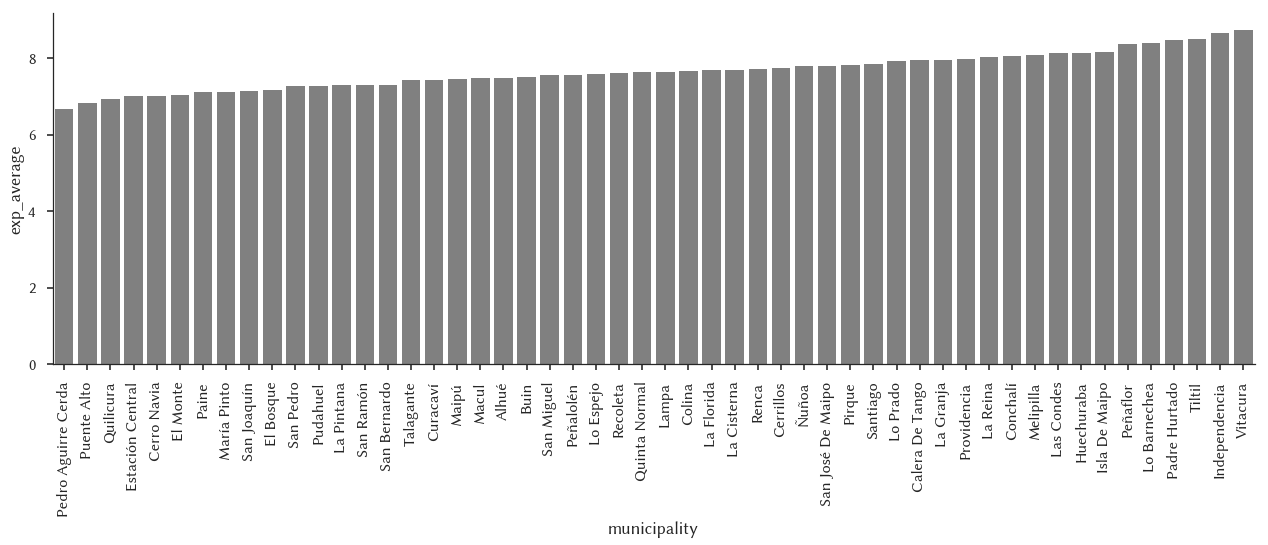

In [30]:
sns.factorplot(x='municipality', y='exp_average', data=satisfaction.reset_index(), 
               aspect=3, size=6, kind='bar',
               order=satisfaction.index, color='grey')
plt.xticks(rotation=90);

Noten que ya no hay barras de error. Esto es porque a `sns.factorplot` le hemos entregado una observación por comuna.

Veamos el puntaje estándar:

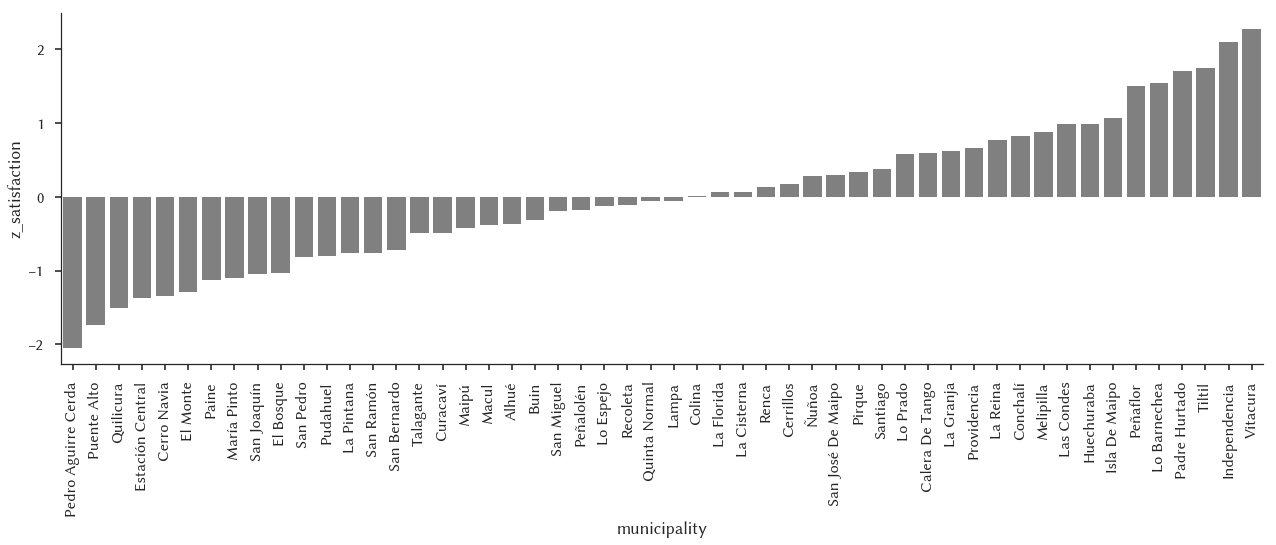

In [31]:
sns.factorplot(x='municipality', y='z_satisfaction', data=satisfaction.reset_index(), 
               aspect=3, size=6, kind='bar',
               order=satisfaction.index, color='grey')
plt.xticks(rotation=90);

Wow, creo que se ve muy bien :)

Considerando cómo calculamos `r20` con expansión, hagamos lo mismo con el ingreso:

In [32]:
# here we can use the municipal expansion (but it's not recommended... je je je)
casen_homes['adjusted_income'] = casen_homes.ytotcorh * casen.expc

income = (casen_homes.groupby('municipality')
                .aggregate({'ytotcorh': 'sum', 'adjusted_income': 'sum'})
                .join(casen_homes.groupby('municipality').aggregate({'expc': 'sum'}))
                .assign(exp_average=lambda x: (x['adjusted_income'] / x['expc']).astype(np.int))
                .rename(columns={'exp_average': 'average_income'}))
#income

Unamos ambos dataframes (ingreso y satisfacción) en uno solo, para poder comparar resultados:

In [33]:
municipality_features = satisfaction.join(income).loc[:,('z_satisfaction', 'average_income')]

Veamos si están correlacionadas ambas características de las municipalidades. Podemos usar el método `sns.jointplot`. Calcularemos la correlación de _spearman_ puesto que nuestras variables no están distribuidas de manera normal (en tal caso hubiésemos podido utilizar la de _pearson_):

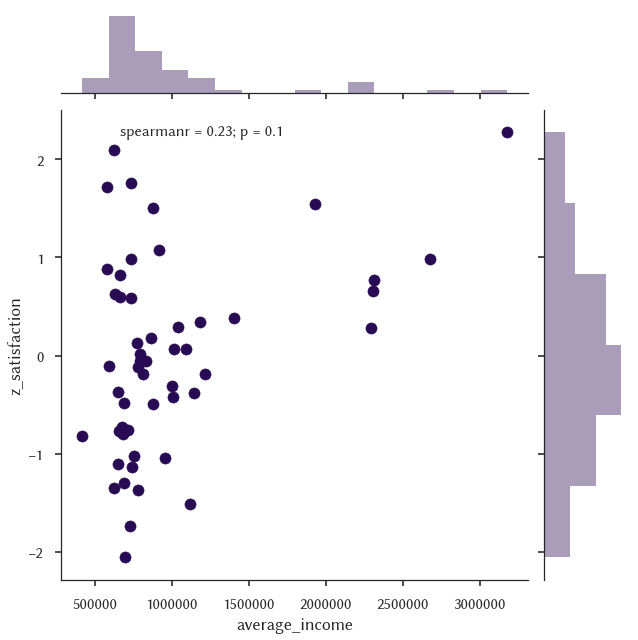

In [34]:
from scipy.stats import spearmanr

sns.jointplot('average_income', 'z_satisfaction', 
              municipality_features,
              size=9, 
              stat_func=spearmanr)

No es una correlación significativa. Pero sí podemos ver que, a ingresos bajos y medios, está todo el espectro de satisfacción, pero que en ingresos altos, no hay comunas insatisfechas.

Este resultado no es nuevo. En un [estudio](http://science.sciencemag.org/content/312/5782/1908.full?casa_token=WDhcGsXTGqMAAAAA:UZXfIidKtiatn-6D5cZSxAIuQpcJ8JSUHX3Q9QSdKxJnZiu0Tk60s4uAT5u--vkzSEBpLMHP4gEABA) de Daniel Kahnemann, titulado _"Would You Be Happier If You Were Richer? A Focusing Illusion,"_ encontraron este mismo resultado. ¡Lo hubiésemos calculado antes! :D

## Encuesta Origen-Destino de Santiago, 2012

La Encuesta Origen-Destino de Santiago, efectuada por última vez el año 2012, es el instrumento principal que utilizan las autoridades para tomar decisiones respecto a transporte en la ciudad. Consistió en entrevistar a los residentes de más de 18000 hogares haciéndoles la siguiente pregunta:

> ¿Cuáles viajes hiciste ayer?

Las personas encuestadas responden a través de un diario de viaje. En este diario incluyen todos los datos pertinentes de sus viajes: a qué hora lo iniciaron, a qué hora terminaron, los puntos de origen y destino (coordenadas), el propósito del viaje, el/los modo(s) de viaje utilizados, etc. También incluye información socio-demográfica de cada persona que responde.

La encuesta es representativa a nivel comunal. Esto quiere decir que podemos sacar conclusiones sobre como se moviliza la población de Providencia, pero no de un barrio específico de la comuna. Puede ser que exista información de ese barrio específico, pero no podemos sacar conclusiones extrapolables al barrio completo.

Lo que haremos entonces es calcular algunas métricas a nivel comunal y correlacionarlas con lo que estimamos en la encuesta CASEN.

In [35]:
# éste es un archivo preprocesado con datos de la encuesta
travel_survey = (pd.read_csv('./intermediate/stgo-travel-survey-2012.csv.gz')
                 .assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
                 .assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
                 .assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
                )
travel_survey.sample(5)

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,Proposito,PropositoAgregado,ActividadDestino,MediosUsados,ModoAgregado,ModoPriPub,ModoMotor,HoraIni,HoraFin,HoraMedia,TiempoViaje,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CodigoTiempo,ModoDifusion,DistEuclidiana,DistManhattan,Imputada,HoraDeInicio,Sexo,TramoIngreso,Ocupacion,JornadaTrabajo,Relacion,origin_latitude,origin_longitude,destination_latitude,destination_longitude,Sector,Comuna,home_latitude,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
56323,2378900101,237890,23789001,2,Quilicura,Quilicura,Norte,Norte,555,542,338939.8438,6307515.5,340767.6875,6310508.5,Al trabajo,1.0,Comercio,3;2,Bus TS,2,1,0 days 13:00:00.000000000,0 days 14:00:00.000000000,13:30,60.0,2.0,"Fuera de Punta 2 (9:01 - 10:00, 12:01 - 17:30,...",5.0,1.0,1.000000,NaN,NaN,NaN,NaN,0.0,Bip!,3507,4821,0,13.00,Hombre,No contesta,Empleado u obrero del sector privado,Jornada completa (40 o más horas semanales),Cónyuge o pareja,-33.359536,-70.731071,-33.332824,-70.710905,Norte,QUILICURA,-33.359990,-70.731177,3,0,0,0,388955,555,13:00:00,14:00:00,60.0
3475,1133810302,113381,11338103,1,Santiago,Conchalí,Centro,Norte,18,100,346199.7188,6298452.5,342799.5938,6306622.5,volver a casa,1.0,NaN,3,Bus TS,2,1,0 days 18:00:00.000000000,0 days 18:30:00.000000000,18:15,30.0,1.0,Punta Tarde (17:31 - 20:30),15.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,Bip!,8849,11570,0,18.00,Hombre,Entre 200.001 y 400.000 pesos,Empleado u obrero del sector privado,Jornada completa (40 o más horas semanales),Hijo o Hija,-33.442312,-70.654620,-33.368159,-70.689758,Norte,CONCHALI,-33.368160,-70.689758,3,0,0,0,880000,100,18:00:00,18:30:00,30.0
15771,1437010205,143701,14370102,1,La Granja,La Granja,Sur,Sur,237,249,348700.3750,6289336.5,348901.2500,6289534.5,De compras,3.0,NaN,8,Caminata,5,2,0 days 17:00:00.000000000,0 days 17:05:00.000000000,17:02,5.0,1.0,"Fuera de Punta 2 (9:01 - 10:00, 12:01 - 17:30,...",5.0,1.0,1.482104,NaN,NaN,NaN,NaN,0.0,Caminata,282,399,0,17.00,Mujer,NaN,NaN,NaN,Cónyuge o pareja,-33.524858,-70.629265,-33.523101,-70.627069,Sur,LA GRANJA,-33.524860,-70.629265,4,1,1,0,307811,237,17:00:00,17:05:00,5.0
39032,1940530201,194053,19405302,2,Ñuñoa,Santiago,Oriente,Centro,423,7,350873.7188,6295409.0,344866.5938,6297777.0,Al estudio,2.0,NaN,5;4,Taxi Colectivo - Metro,2,1,0 days 07:15:00.000000000,0 days 08:20:00.000000000,7:47,65.0,3.0,Punta Mañana 2 (7:31 - 9:00),15.0,4.0,0.817907,NaN,NaN,NaN,NaN,0.0,Bip! - Otros Público,6457,8375,0,7.25,Hombre,NaN,NaN,NaN,Hijo o Hija,-33.470413,-70.604859,-33.448210,-70.669073,Oriente,ÑUÑOA,-33.470413,-70.604858,3,0,1,0,669964,423,07:15:00,08:20:00,65.0
13823,1401210201,140121,14012102,1,La Florida,Santiago,Sur-Oriente,Centro,208,33,350746.8750,6286423.5,347643.0000,6297371.0,Al trabajo,1.0,Industria,1,Auto,1,1,0 days 08:00:00.000000000,0 days 08:30:00.000000000,8:15,30.0,1.0,Punta Mañana 2 (7:31 - 9:00),0.0,0.0,1.043074,NaN,NaN,NaN,NaN,0.0,Auto,11379,14051,0,8.00,Hombre,Entre 200.001 y 400.000 pesos,Empleado u obrero del sector privado,Jornada completa (40 o más horas semanales),Cónyuge o pareja,-33.551410,-70.607721,-33.452269,-70.639281,Sur-Oriente,LA FLORIDA,-33.551410,-70.607721,4,1,0,1,300000,208,08:00:00,08:30:00,30.0


In [36]:
travel_survey.columns

Index(['Viaje', 'Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
       'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
       'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
       'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
       'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
       'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
       'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
       'FactorDomingoNormal', 'FactorLaboralEstival',
       'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
       'DistEuclidiana', 'DistManhattan', 'Imputada', 'HoraDeInicio', 'Sexo',
       'TramoIngreso', 'Ocupacion', 'JornadaTrabajo', 'Relacion',
       'origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'Sector', 'Comuna', 'home_latitude',
       'home_longitude', 'NumPer', 'NumVeh', 'NumBicAdulto', 'NumBicNino',
  

Limpiaremos un poco los viajes para que podamos entender mejor los resultados.

In [37]:
# viajes con distancia mayor a 250 metros
travel_survey = travel_survey[(travel_survey.DistManhattan >= 250)
                  # el dataset no incluye el "especifique" así que lo sacamos
                  & (travel_survey.Proposito != 'Otra actividad (especifique)')
                  # estamos analizando la RM así que sacamos viajes fuera de ésta
                  & (~travel_survey.SectorOrigen.isin(['Exterior a RM'])) 
                  & (~travel_survey.Sector.isin(['Exterior a RM']))
                  & (~travel_survey.SectorDestino.isin(['Exterior a RM']))
                  # para los modos de viaje, tampoco se indica qué es "otros"
                  & ~(travel_survey.ModoDifusion == 'Otros')].copy()

In [38]:
travel_survey.shape, travel_survey.columns

((67320, 62),
 Index(['Viaje', 'Hogar', 'Persona', 'Etapas', 'ComunaOrigen', 'ComunaDestino',
        'SectorOrigen', 'SectorDestino', 'ZonaOrigen', 'ZonaDestino',
        'OrigenCoordX', 'OrigenCoordY', 'DestinoCoordX', 'DestinoCoordY',
        'Proposito', 'PropositoAgregado', 'ActividadDestino', 'MediosUsados',
        'ModoAgregado', 'ModoPriPub', 'ModoMotor', 'HoraIni', 'HoraFin',
        'HoraMedia', 'TiempoViaje', 'TiempoMedio', 'Periodo', 'MinutosDespues',
        'CuadrasDespues', 'FactorLaboralNormal', 'FactorSabadoNormal',
        'FactorDomingoNormal', 'FactorLaboralEstival',
        'FactorFindesemanaEstival', 'CodigoTiempo', 'ModoDifusion',
        'DistEuclidiana', 'DistManhattan', 'Imputada', 'HoraDeInicio', 'Sexo',
        'TramoIngreso', 'Ocupacion', 'JornadaTrabajo', 'Relacion',
        'origin_latitude', 'origin_longitude', 'destination_latitude',
        'destination_longitude', 'Sector', 'Comuna', 'home_latitude',
        'home_longitude', 'NumPer', 'NumVeh', 'Num

Visualicemos los propósitos de viaje de las personas:

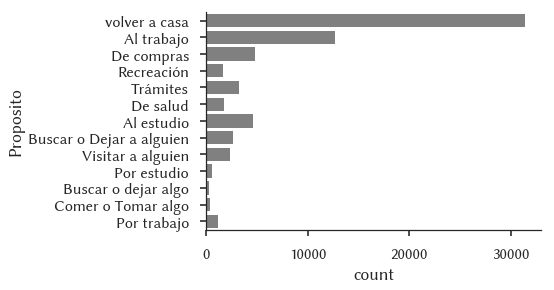

In [39]:
sns.countplot(y='Proposito', data=travel_survey, color='grey')
sns.despine()

Observamos que el propósito más común es "volver a casa." Esto es esperado, puesto que todos los demás propósitos implican un retorno a algún lugar, excepto casos especiales.

Ahora utilicemos `sns.distplot` para ver a qué hora comienzan los viajes en la RM:

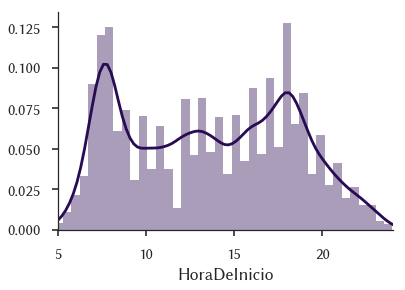

In [40]:
sns.distplot(travel_survey.HoraDeInicio)
plt.xlim([5, 24])
sns.despine()

Aquí hay dos cosas interesantes.

  1. Observen el patrón dentado del histograma. ¿A qué se debe? Recuerden que este dataset es una encuesta, por lo que la hora de inicio de viaje es la **reportada** por las personas. Tendemos a redondear los valores que reportamos. Nadie dice "salí a las una, doce minutos, 3 segundos," sino que se dice "salí a las una y cuarto." En ese aspecto, la estimación de la distribución utilizando Kernel Density Estimation funciona bien.
  2. En el gráfico se observan tres horas _peak_: las dos usuales (punta mañana y punta tarde) y un tercer peak a la hora de almuerzo. Ahora bien, dadas las rutinas diarias de las personas, seguramente cada peak obedece a propósitos de viaje distinto.
  
Entonces desagregemos por propósito de viaje:

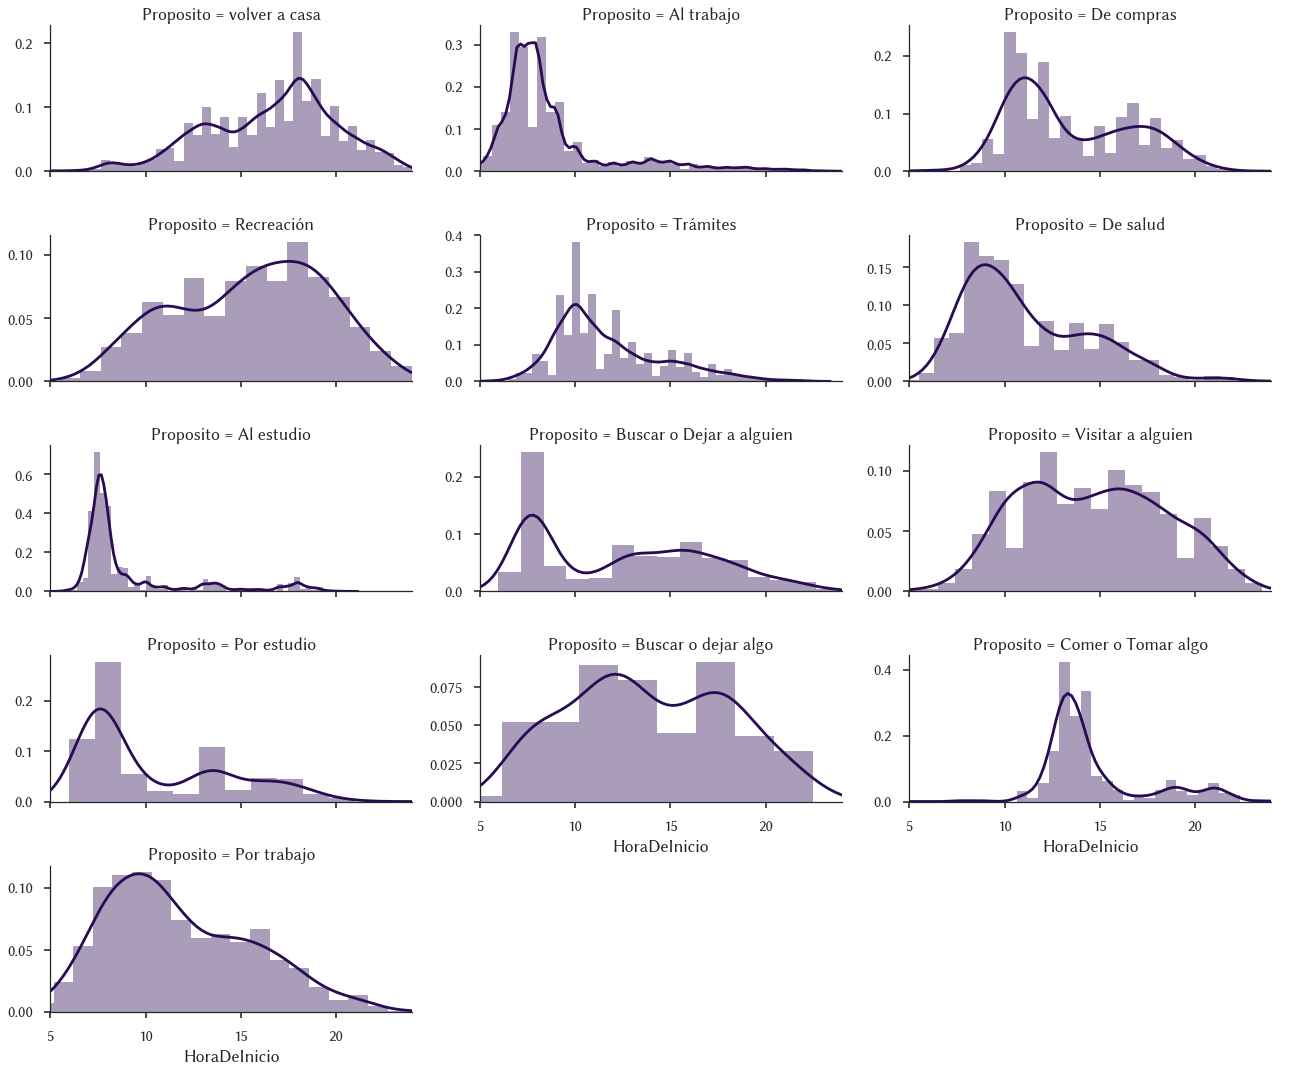

In [41]:
g = sns.FacetGrid(data=travel_survey, col='Proposito', col_wrap=3, aspect=2, sharey=False)
g.map(sns.distplot, 'HoraDeInicio')
g.add_legend()
g.set(xlim=[5,24])

Siguiendo la tónica que tuvimos cuando analizamos la CASEN, podríamos preguntarnos si existen diferencias de sexo en estos patrones. Esto lo podemos hacer de maneraq directa con el parámetro `hue='Sexo'`:

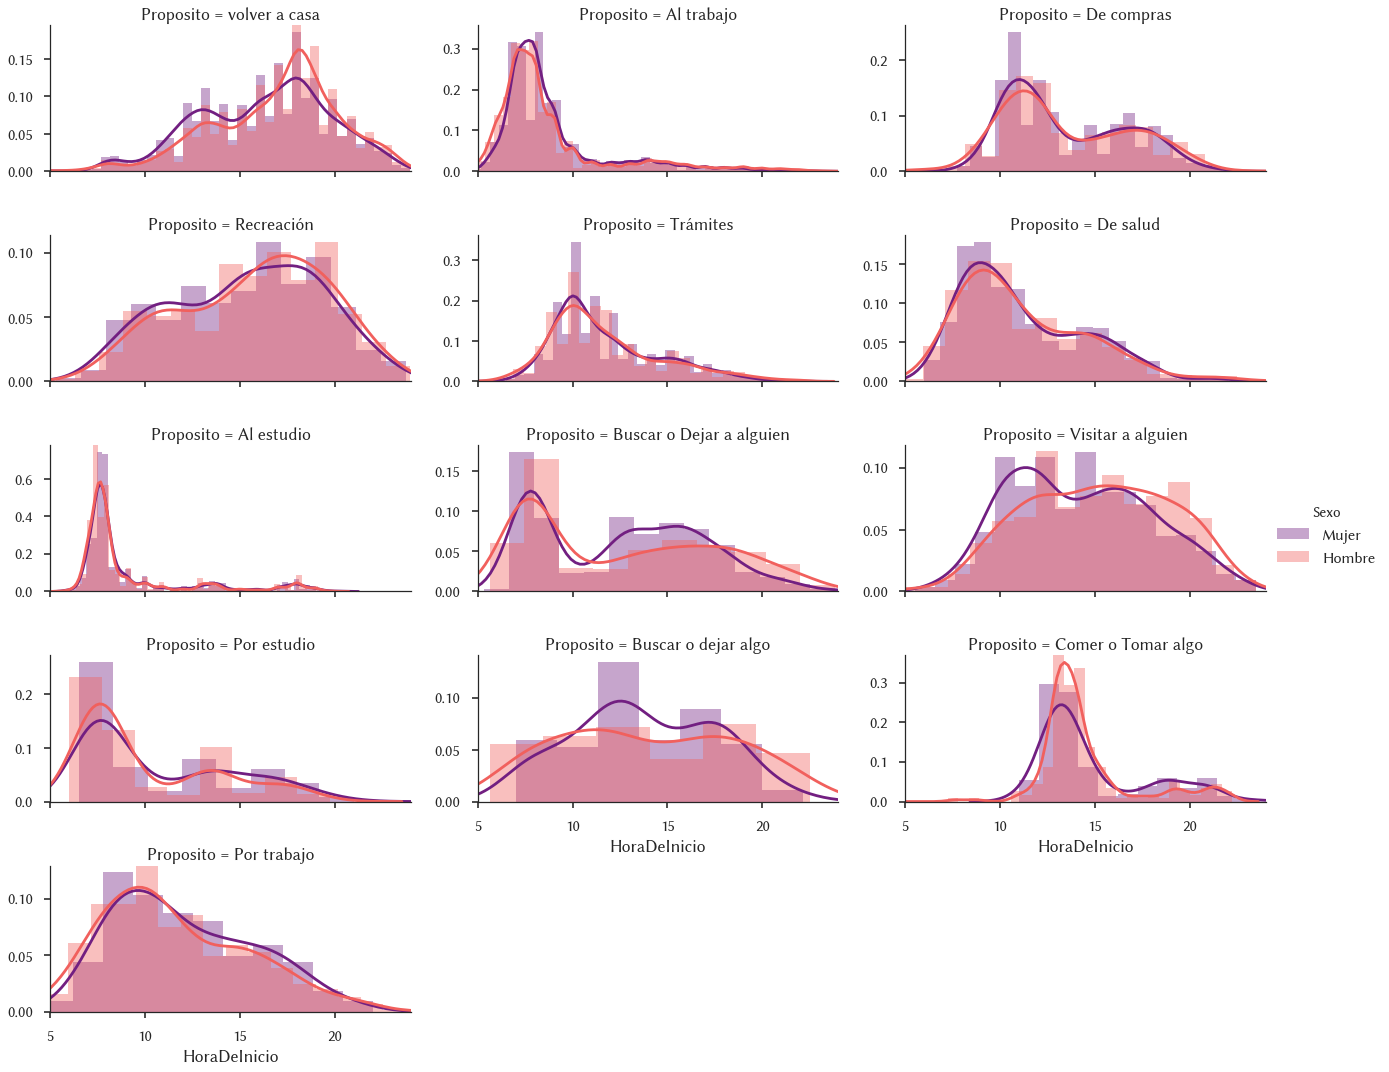

In [42]:
g = sns.FacetGrid(data=travel_survey, col='Proposito', hue='Sexo',
                  col_wrap=3, aspect=2, sharey=False, palette='magma')
g.map(sns.distplot, 'HoraDeInicio')
g.add_legend()
g.set(xlim=[5,24])

Oh, vemos que algunos propósitos de viaje no exhiben diferencias en sus distribuciones, pero otros sí. Queda propuesta la interpretación de estos gráficos.

Ahora veamos la _partición modal_ de cada comuna. Partición modal se refiere a la distribución de los modos de transporte utilizados, a un nivel específico. Por ejemplo, si queremos saber la partición modal de los viajes al trabajo, podemos usar `sns.countplot`:

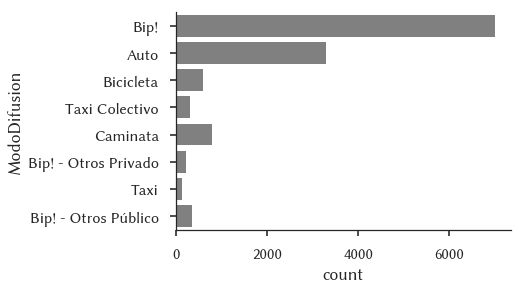

In [43]:
sns.countplot(y='ModoDifusion', data=travel_survey[travel_survey.Proposito == 'Al trabajo'], 
              color='grey')
sns.despine()

Pero también podemos querer calcular la partición modal por sectores de la ciudad. Para eso, utilizaremos la operación `groupby` de `pandas` (nota: `FactorLaboralNormal` es el factor de expansión o ponderación para los viajes realizados en días laborales no estivales):

In [44]:
travel_survey.groupby(['Sector', 'ModoDifusion']).aggregate({'FactorLaboralNormal': 'sum'})

FactorLaboralNormal
Sector      ModoDifusion                             
Centro      Auto                           373.825487
            Bicicleta                      156.734383
            Bip!                          1146.995473
            Bip! - Otros Privado            36.968392
            Bip! - Otros Público            18.727177
            Caminata                      1276.992084
            Taxi                           117.533386
            Taxi Colectivo                   6.734072
Norte       Auto                          1211.668507
            Bicicleta                      205.066164
            Bip!                          2910.496585
            Bip! - Otros Privado            31.306811
            Bip! - Otros Público            42.803122
            Caminata                      1045.753466
            Taxi                            93.565935
            Taxi Colectivo                 155.898319
Oriente     Auto                          7941.846271
            Bicicleta                      711.337646
            Bip!                          3209.779571
            Bip! - Otros Privado           174.376907
            Bip! - Otros Público            43.086405
            Caminata                      1711.567761
            Taxi                           408.412242
            Taxi Colectivo                  60.944868
Poniente    Auto                          2429.794671
            Bicicleta                      380.680273
            Bip!                          5262.947858
            Bip! - Otros Privado            88.210611
            Bip! - Otros Público           232.074822
            Caminata                      2362.066916
            Taxi                           199.677713
            Taxi Colectivo                 414.996672
Sur         Auto                          2408.024595
            Bicicleta                      380.858882
            Bip!                          4094.747894
            Bip! - Otros Privado            99.919688
            Bip! - Otros Público           265.666855
            Caminata                      2509.460235
            Taxi                           349.675351
            Taxi Colectivo                 787.449354
Sur-Oriente Auto                          3008.636269
            Bicicleta                      253.846385
            Bip!                          4967.925957
            Bip! - Otros Privado           172.769196
            Bip! - Otros Público           261.672899
            Caminata                      1800.748573
            Taxi                           195.692487
            Taxi Colectivo                 575.291902

Lo que quisiéramos hacer con esta tabla es normalizarla por sectores y visualizarla como un heatmap. Lo podemos hacer mezclando ambas cosas: la operación descrita y la función `sns.heatmap`:

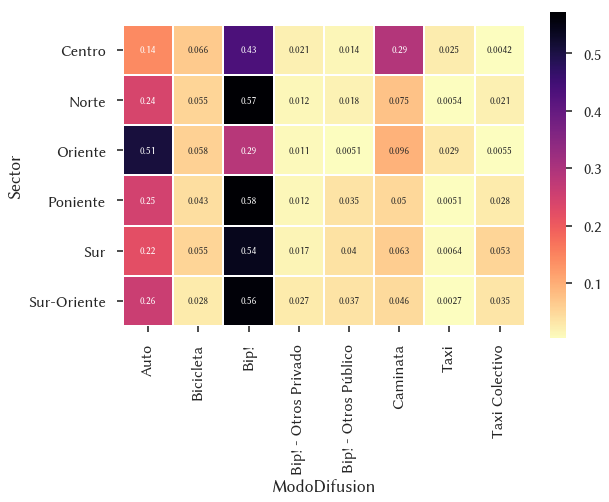

In [45]:
modal_partition = (travel_survey[travel_survey.Proposito == 'Al trabajo']
                   .groupby(['Sector', 'ModoDifusion'])
                   .aggregate({'FactorLaboralNormal': 'sum'})
                   .reset_index()
                   # Arriba vemos cómo queda el resultado.
                   # Para la función heatmap necesitamos que el formato sea "longform"
                   # Eso lo logramos con pivot_table
                   .pivot_table(index='Sector', values='FactorLaboralNormal', columns='ModoDifusion')
                   # Esto permite normalizar cada fila. 
                   # https://stackoverflow.com/questions/18594469/normalizing-a-pandas-dataframe-by-row#18594595
                   .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
                  )

plt.figure(figsize=(9,6))
sns.heatmap(modal_partition, cmap='magma_r', annot=True, linewidth=1, square=True, robust=True)

Encontramos lo que todos sabemos: que el sector oriente es muy distinto al resto en lo que respecta al uso de tarjeta Bip! y autos. 

Pero también vemos que el centro también es diferente - quienes viven allí tienen una mayor tasa de viajes caminando al trabajo. ¡Qué envidia! 

Realicemos este mismo cálculo a nivel municipalidad:

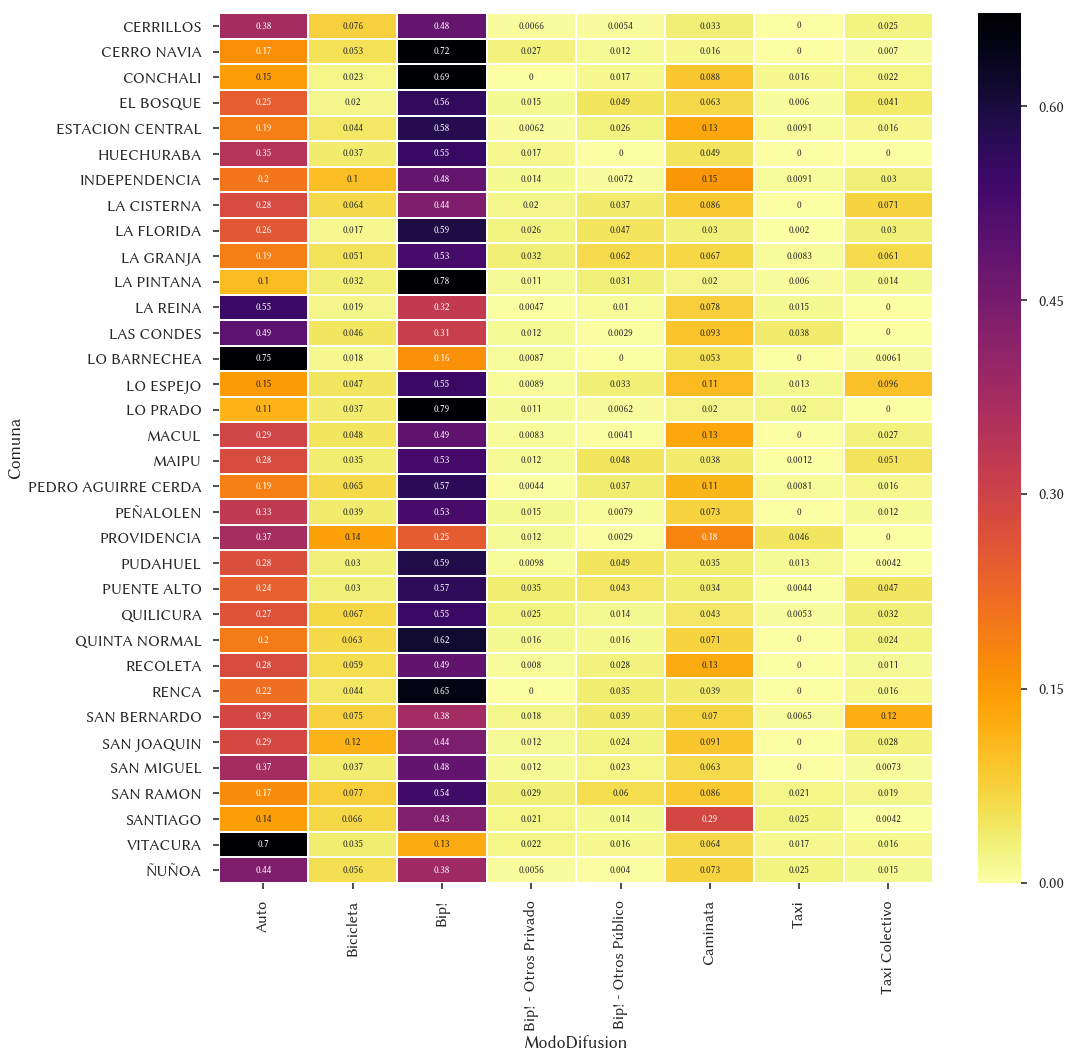

In [46]:
municipality_modal_partition = (travel_survey[travel_survey.Proposito == 'Al trabajo']
                   .groupby(['Comuna', 'ModoDifusion'])
                   .aggregate({'FactorLaboralNormal': 'sum'})
                   .reset_index()
                   .pivot_table(index='Comuna', values='FactorLaboralNormal', columns='ModoDifusion')
                   .fillna(0)
                   .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
                  )

plt.figure(figsize=(16,16))
sns.heatmap(municipality_modal_partition, cmap='inferno_r', annot=True, linewidth=1, 
            robust=True)

Esto es más difícil de observar. Noten que las filas están ordenadas alfabéticamente, lo que permite su fácil localización, pero al mismo tiempo dificulta las comparaciones.

Quisiéramos que las filas y columnas que se parecen entre sí aparecieran juntas, de modo de poder hacer comparaciones de manera más fácil.

Para eso está `sns.clustermap`:

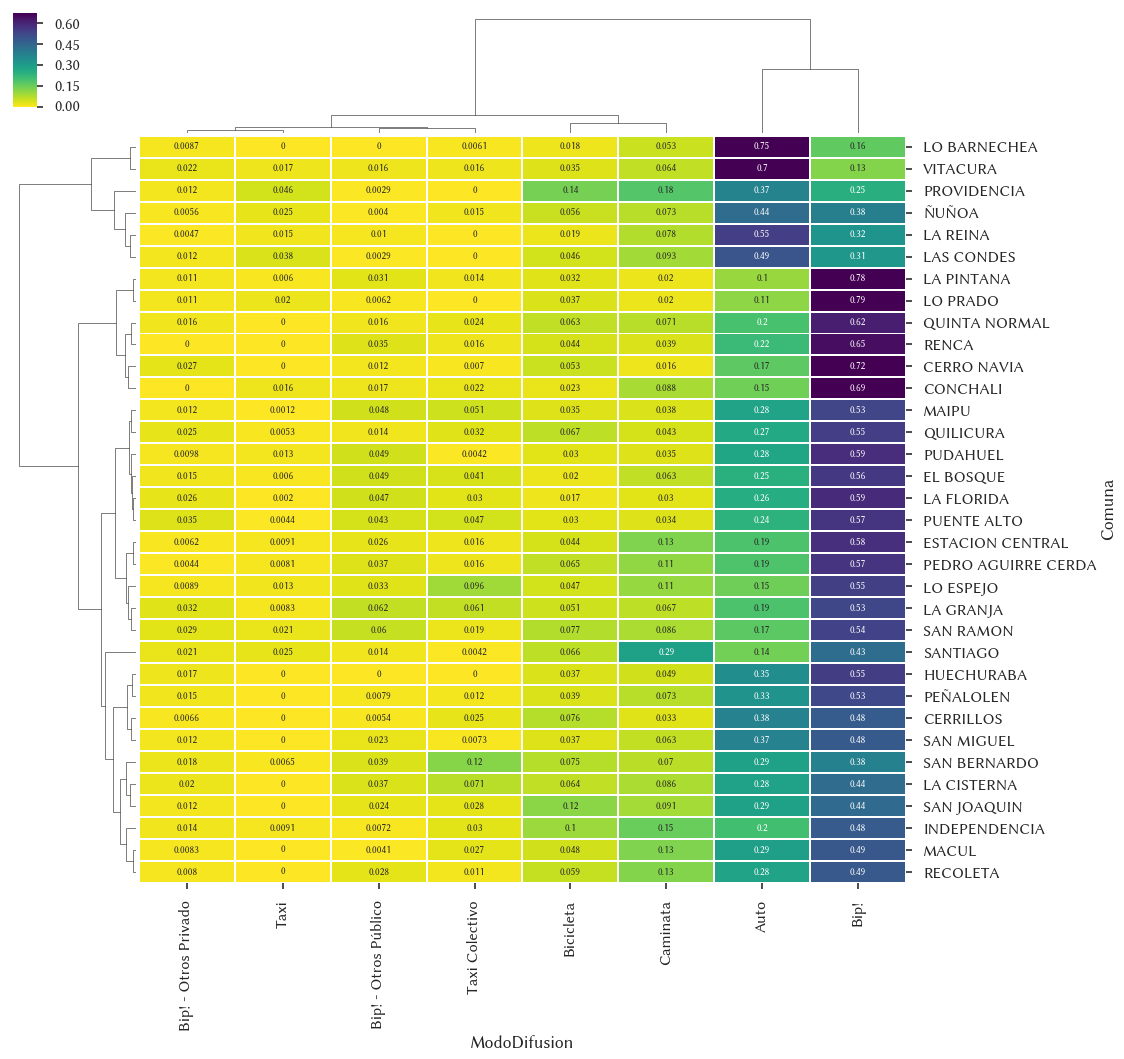

In [47]:
g = sns.clustermap(municipality_modal_partition, cmap='viridis_r', annot=True, linewidth=1, figsize=(16,16),
            metric='euclidean', method='ward', square=False, robust=True, 
            yticklabels=True)

Ahora imaginen que con estos métodos se pueden visualizar otras variables. Queda propuesto ese ejercicio :)

Revisemos uno de los outpus más conocidos de la Encuesta Origen Destino: la matriz OD.

Definiremos una función que se llama `visualize_flow` y que recibe un dataframe de viajes.

In [48]:
from sklearn.preprocessing import normalize

def visualize_flow(dataframe):
    flujos = (dataframe.groupby(['ComunaOrigen', 'ComunaDestino'])
              .aggregate({'FactorLaboralNormal': 'sum'})
              .reset_index())
    flujos_comunales = pd.pivot_table(flujos, index='ComunaOrigen', columns='ComunaDestino', values='FactorLaboralNormal').fillna(0)
    normalize(flujos_comunales, norm='l1', axis=1, copy=False)
    g = sns.clustermap(flujos_comunales, cmap='inferno_r', square=True, linewidths=1, 
                   metric='cosine', method='ward')
    # esto borra el clustermap
    plt.clf()
    plt.figure(figsize=(16, 16))
    sns.heatmap(g.data2d, cmap='inferno_r', square=True, linewidths=1, cbar_kws={'shrink': 0.4},
               xticklabels=True, yticklabels=True)

Lo que hace esta función es contar los viajes de una comuna a otra (de `ComunaOrigen` a `ComunaDestino`). Luego hace la misma normalización que hicimos en los heatmaps anteriores. 

Partamos viendo los viajes al trabajo/al estudio, luego los de salud y finalmente los de compras:

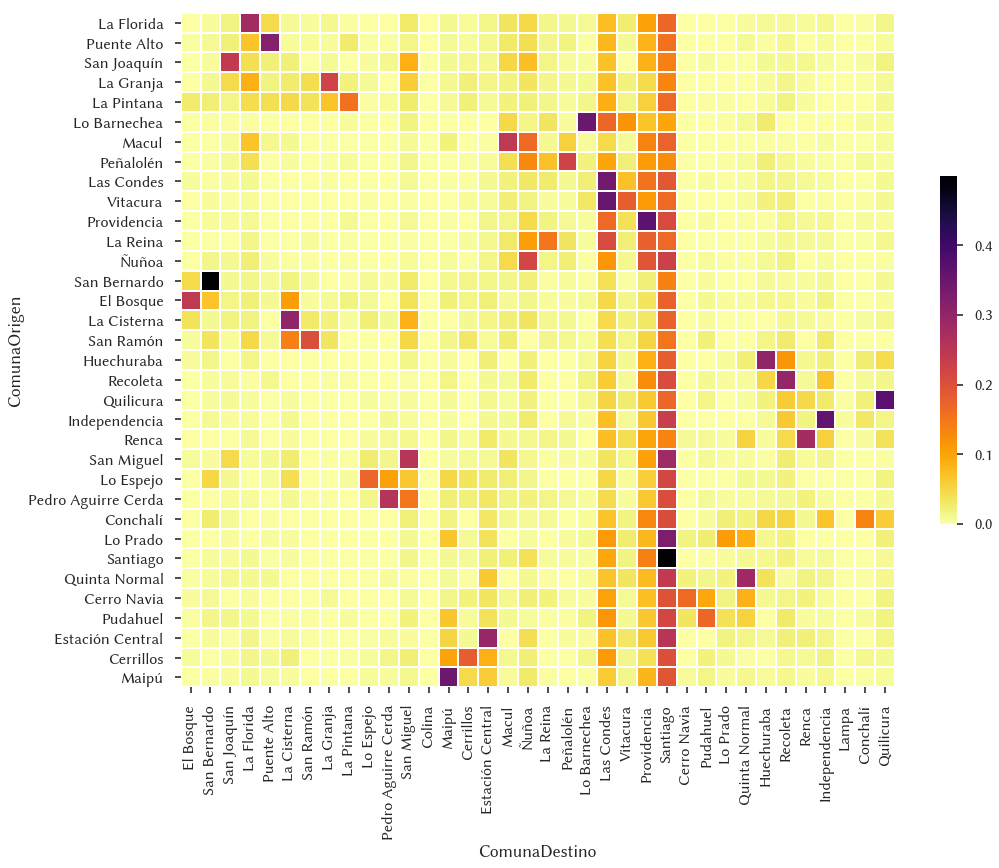

In [49]:
visualize_flow(travel_survey[travel_survey['Proposito'].isin(['Al trabajo', 'Al estudio'])])

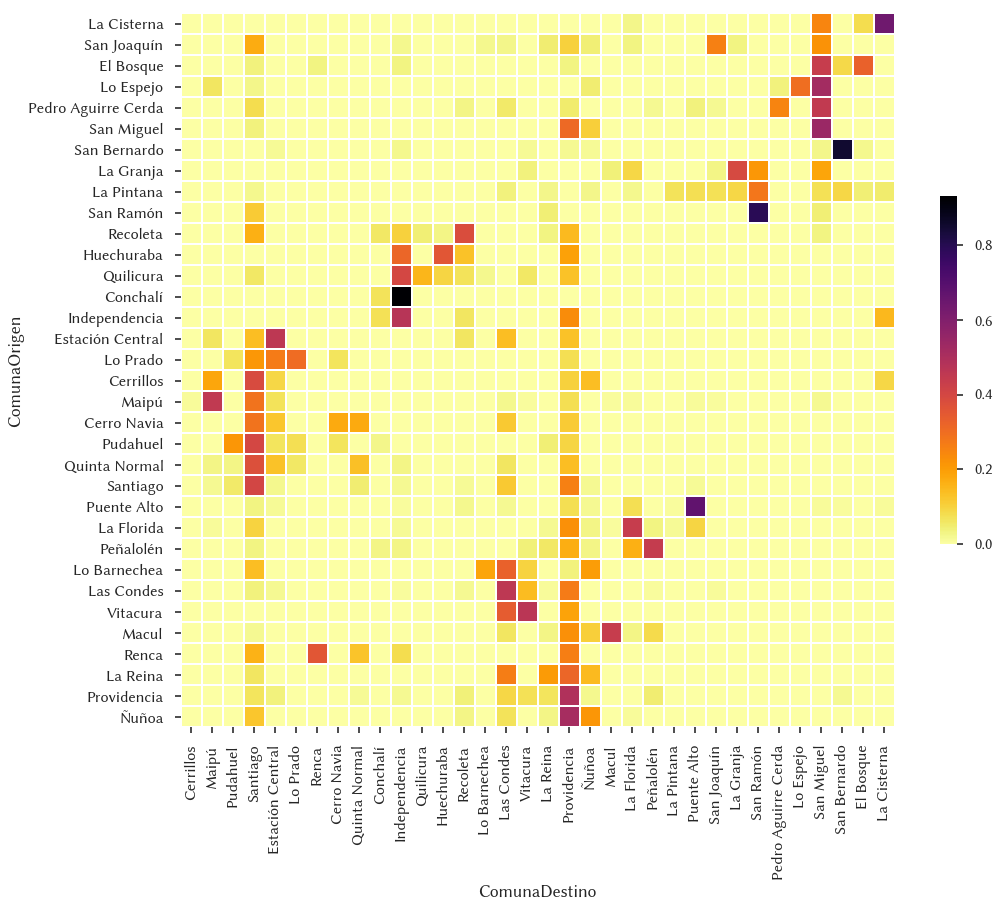

In [50]:
visualize_flow(travel_survey[travel_survey['Proposito'].isin(['De salud'])])

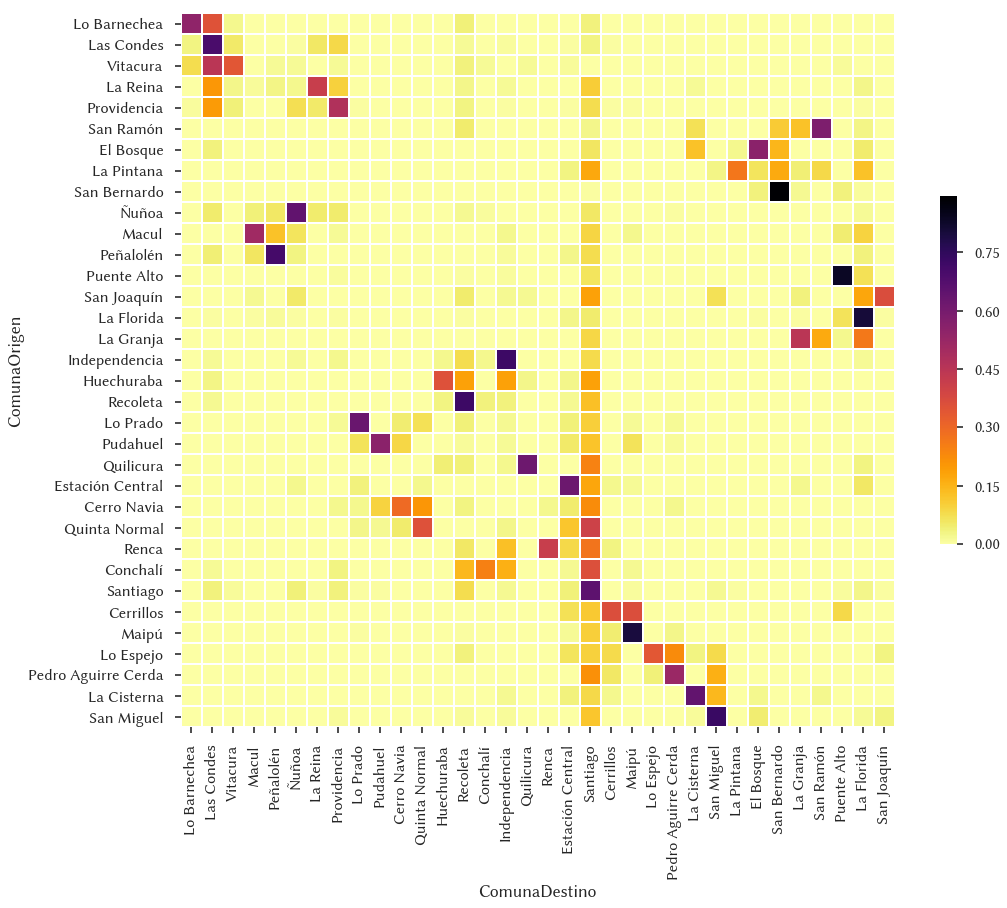

In [51]:
visualize_flow(travel_survey[travel_survey['Proposito'].isin(['De compras'])])

Nuevamente, el análisis queda propuesto.

¡Con esto ya tienen un buen set de visualizaciones estadísticas para explorar datos! :)

Pero todavía no terminamos.

### ¿Cómo cruzar ambos datasets?

Haremos un pequeño ejercicio. Digamos que queremos comparar variables entre la CASEN y la EOD.

La primera dificultad es que los nombres de comuna por hogar en la EOD tienen nombres que no son idénticos a los de la CASEN:

In [52]:
travel_survey.Comuna.sample(5)

30946           MAIPU
47959        PUDAHUEL
63686    SAN BERNARDO
67654       SAN RAMON
67589       SAN RAMON
Name: Comuna, dtype: object

Además de que está todo en mayúscula, no incorpora los tildes.

Podemos hacer una función en Python utilizando el módulo `difflib`, que tiene una clase llamada `SequenceMatcher` que nos dice qué tanto se parece una secuencia a otra. 

Si encapsulamos `SequenceMatcher` en una función, y llamamos a esa función con Peñalolén como prueba, pasa esto:

In [53]:
import difflib

def similar(a, b):
    return difflib.SequenceMatcher(None, a.lower(), b.lower()).ratio()

similar('PEÑALOLEN', 'Peñalolén')

0.8888888888888888

El valor que aparece ahí va entre `0` (nada en común) y `1` (iguales). En este caso, vemos que funciona bastante bien.

Lo que haremos será crear un diccionario. Así:

In [54]:
from itertools import product

muni_name_map = {}

for a, b in product(municipality_modal_partition.index, municipalities_by_home_income.index):
    if similar(a, b) > 0.75:
        print('Original:', a, '| Similar:', b, '. Ratio:', similar(a, b))
        muni_name_map[a] = b

Original: CERRILLOS | Similar: Cerrillos . Ratio: 1.0
Original: CERRO NAVIA | Similar: Cerro Navia . Ratio: 1.0
Original: CONCHALI | Similar: Conchalí . Ratio: 0.875
Original: EL BOSQUE | Similar: El Bosque . Ratio: 1.0
Original: ESTACION CENTRAL | Similar: Estación Central . Ratio: 0.9375
Original: HUECHURABA | Similar: Huechuraba . Ratio: 1.0
Original: INDEPENDENCIA | Similar: Independencia . Ratio: 1.0
Original: LA CISTERNA | Similar: La Cisterna . Ratio: 1.0
Original: LA FLORIDA | Similar: La Florida . Ratio: 1.0
Original: LA GRANJA | Similar: La Granja . Ratio: 1.0
Original: LA PINTANA | Similar: La Pintana . Ratio: 1.0
Original: LA REINA | Similar: La Reina . Ratio: 1.0
Original: LAS CONDES | Similar: Las Condes . Ratio: 1.0
Original: LO BARNECHEA | Similar: Lo Barnechea . Ratio: 1.0
Original: LO ESPEJO | Similar: Lo Espejo . Ratio: 1.0
Original: LO PRADO | Similar: Lo Prado . Ratio: 1.0
Original: MACUL | Similar: Macul . Ratio: 1.0
Original: MAIPU | Similar: Maipú . Ratio: 0.8
O

Ahora crearemos una nueva columna utilizando el diccionario, y finalmente uniremos los dataframes con características municipales que hemos calculado para ambas encuestas:

In [55]:
municipality_modal_partition['municipality'] = [muni_name_map[x] for x in municipality_modal_partition.index]
municipality_modal_partition.set_index('municipality', inplace=True)

In [56]:
municipality_features = municipality_features.join(municipality_modal_partition)
municipality_features.head()

,z_satisfaction,average_income,Auto,Bicicleta,Bip!,Bip! - Otros Privado,Bip! - Otros Público,Caminata,Taxi,Taxi Colectivo
municipality,,,,,,,,,,
Pedro Aguirre Cerda,-2.052627,696279,0.187590,0.065174,0.571386,0.004447,0.036675,0.110551,0.008059,0.016118
Puente Alto,-1.731030,726208,0.240268,0.029589,0.566997,0.034681,0.043119,0.034357,0.004431,0.046559
Quilicura,-1.506401,1115318,0.265188,0.067266,0.548850,0.024727,0.013892,0.043196,0.005292,0.031589
Estación Central,-1.367670,778254,0.189007,0.044390,0.579838,0.006164,0.025787,0.129492,0.009136,0.016187
Cerro Navia,-1.347633,621411,0.167332,0.053149,0.717149,0.027055,0.012241,0.016072,0.000000,0.007001


El siguiente paso es crear una matriz de correlaciones entre columnas de este dataframe:

In [57]:
corr = municipality_features.corr(method='spearman')
corr.sample(5)

,z_satisfaction,average_income,Auto,Bicicleta,Bip!,Bip! - Otros Privado,Bip! - Otros Público,Caminata,Taxi,Taxi Colectivo
Bip! - Otros Privado,-0.112614,-0.065093,-0.105738,0.131866,-0.029338,1.000000,0.271088,-0.227061,-0.038047,0.286021
Bicicleta,-0.099771,-0.071963,-0.068296,1.000000,-0.287395,0.131866,-0.139659,0.478992,0.055153,0.173374
z_satisfaction,1.000000,0.228891,0.357066,-0.099771,-0.447517,-0.112614,-0.521048,0.165164,0.264827,-0.353329
Taxi Colectivo,-0.353329,-0.220811,-0.216527,0.173374,0.084315,0.286021,0.581835,-0.000765,-0.215003,1.000000
Bip!,-0.447517,-0.616807,-0.748510,-0.287395,1.000000,-0.029338,0.354343,-0.453629,-0.178739,0.084315


Una matriz que podemos visualizar con `sns.heatmap`:

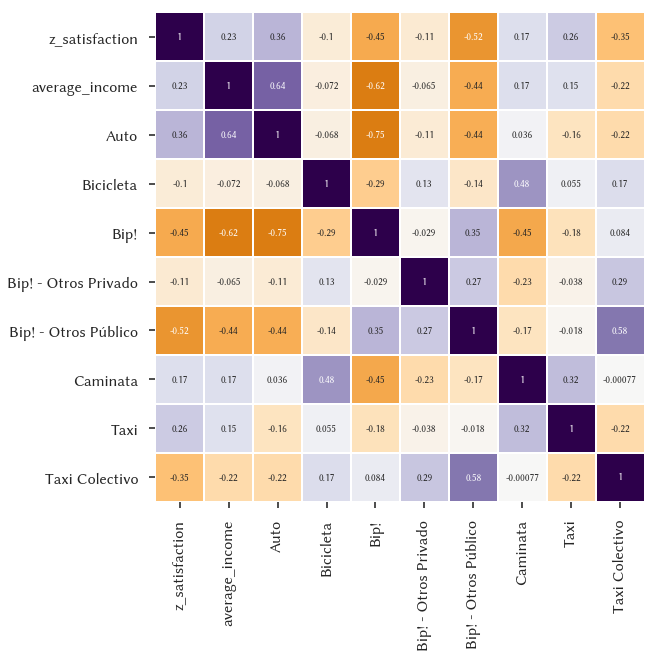

In [58]:
plt.figure(figsize=(9,9))
sns.heatmap(corr, square=True, annot=True, robust=True, center=0, cmap='PuOr', linewidth=1,
           cbar=False)

Nuevamente, dejo propuesta la interpretación de este gráfico.

Guardaremos los resultados de nuestro análisis para explorarlo en la siguiente clase:

In [59]:
municipality_features

,z_satisfaction,average_income,Auto,Bicicleta,Bip!,Bip! - Otros Privado,Bip! - Otros Público,Caminata,Taxi,Taxi Colectivo
municipality,,,,,,,,,,
Pedro Aguirre Cerda,-2.052627,696279,0.187590,0.065174,0.571386,0.004447,0.036675,0.110551,0.008059,0.016118
Puente Alto,-1.731030,726208,0.240268,0.029589,0.566997,0.034681,0.043119,0.034357,0.004431,0.046559
Quilicura,-1.506401,1115318,0.265188,0.067266,0.548850,0.024727,0.013892,0.043196,0.005292,0.031589
Estación Central,-1.367670,778254,0.189007,0.044390,0.579838,0.006164,0.025787,0.129492,0.009136,0.016187
Cerro Navia,-1.347633,621411,0.167332,0.053149,0.717149,0.027055,0.012241,0.016072,0.000000,0.007001
El Monte,-1.294248,691196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paine,-1.131220,737329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
María Pinto,-1.104974,646344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
San Joaquín,-1.047596,953264,0.287268,0.116917,0.441007,0.011997,0.024081,0.090580,0.000000,0.028150


In [60]:
municipality_features.to_csv('./intermediate/municipality_features.csv')

In [61]:
!head intermediate/municipality_features.csv

municipality,z_satisfaction,average_income,Auto,Bicicleta,Bip!,Bip! - Otros Privado,Bip! - Otros Público,Caminata,Taxi,Taxi Colectivo
Pedro Aguirre Cerda,-2.052626855899623,696279,0.18759046205329577,0.06517369732153847,0.5713856284942501,0.004447344505326975,0.03667474495584305,0.11055144784051672,0.008058891609742993,0.016117783219485985
Puente Alto,-1.7310299614775349,726208,0.24026831045584365,0.029588721416726117,0.5669966593783563,0.03468123240947506,0.043118675616928365,0.0343566986932338,0.004430923839257713,0.04655877819017903
Quilicura,-1.5064012232724109,1115318,0.26518784043743726,0.06726588243106801,0.5488502474565116,0.02472742079943569,0.013892057545818386,0.04319553191717784,0.005291695345170403,0.03158932406738078
Estación Central,-1.3676698351934882,778254,0.18900689152035,0.04439004132438574,0.5798375473102253,0.0061639962608288894,0.025786848933236826,0.12949243705917637,0.009135682959399876,0.01618655463239705
Cerro Navia,-1.3476330996418238,621411,0.16733193751936